# DS210 - DeepLearning Sentiment Portfolio (DSP)
## Benchmark Model
### Irene Na

## Set the environment

In [1]:
# !pip install --upgrade wrds --quiet
# !pip install  --upgrade openpyxl -- quiet
# !pip install yfinance --quiet
# !pip install PyPortfolioOpt --quiet
# !pip install cvxopt --quiet
# !pip install cvxpy --quiet
# !pip install openpyxl -- quiet


import wrds
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os 
import yfinance as yf
import importlib
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pypfopt import (
    EfficientFrontier, 
    risk_models,
    plotting,
    # fix_nonpositive_semidefinite
)
import cvxpy as cp
import warnings
# warnings.filterwarnings("ignore")
warnings.filterwarnings('default')
from sklearn.covariance import LedoitWolf
from joblib import Parallel, delayed
import time
import pickle

import openpyxl
print(openpyxl.__version__) 

# display(cp.installed_solvers())

c:\Users\SngeN\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


3.1.5


In [2]:
# # check if matplotlib and dependencies are installed properly
import matplotlib
print('matplotlib version is:')
# print(matplotlib.__file__)
print(matplotlib.__version__)

print('Pandas version is:')
print(pd.__version__)

matplotlib version is:
3.10.1
Pandas version is:
2.2.3


In [286]:
warnings.filterwarnings('once')

In [8]:
# import other modules
import ds210_ml_portf_data_retrieval as data_unit

In [80]:
# IN: if edited the imported file you need to reload the import as below to update the function
import importlib
importlib.reload(data_unit)

<module 'ds210_ml_portf_data_retrieval' from 'c:\\Mine\\U.S.-2019\\NPB living - 2 - related\\School-part time\\Berkeley-202308\\MIDS classes\\210-Capstone\\Project-related\\code-IN\\ds210_ml_portf_data_retrieval.py'>

## Reference:
- https://pyportfolioopt.readthedocs.io/en/stable/index.html
- https://github.com/robertmartin8/PyPortfolioOpt/tree/master
- https://github.com/caopuzheng/capstone-2024-summer/blob/master/src/ray/Baseline.ipynb

## Functions

In [3]:
def rolling_regression_sm(df_y, df_x, rolling_window, min_nobs):
    # note: the input in sm needs to be either np array or pd series, either works under sm regression
    idx1 = df_x.dropna(how='all').index
    idx2 = df_y.dropna(how='all').index
    idx_comm = idx1.intersection(idx2, sort=False)
    x = df_x.reindex(idx_comm)
    y = df_y.reindex(idx_comm)
    
    x = sm.add_constant(x, has_constant='add')
    model_prefit = RollingOLS(y, x, window=rolling_window, min_nobts=min_nobs)
    sm_model = model_prefit.fit() # normal OLS
    # sm_model = model_prefit.fit_regularized(L1_wt=1.0, alpha=0.001) # lasso
    param_reg = sm_model.params
    return x, y, sm_model, model_prefit, param_reg

def regression_sm(df_y, df_x):
    idx1 = df_x.dropna(how='all').index
    idx2 = df_y.dropna(how='all').index
    
    index_comm = idx1.intersection(idx2, sort=False)
    df_Y = df_y.reindex(index_comm)
    df_X = df_x.reindex(index_comm)
    
    x, y = df_X, df_Y
    x = sm.add_constant(x, has_constant='add')
    model_prefit = sm.OLS(y,x)
    sm_model = model_prefit.fit()
    param_reg = sm_model.params
    return x, y, sm_model, model_prefit, param_reg

def optimizer_ef(ann_exp_exc_rtn, ann_cov_matrix, opt_flag, target_risk, 
                 solver_name='CLARABEL', market_neutral=False):
    ef_ob = EfficientFrontier(ann_exp_exc_rtn, ann_cov_matrix)
    ef_ob._solver = solver_name # IN: 'CLARABEL', this solver works for max_sharpe choice, and likely better for 'target_risk' too
    # ef_ob._solver_options ={'ECOS':cp.ECOS}
    # ef_ob._solver = 'ECOS'

    if opt_flag == 'target_risk':
        ef_ob.efficient_risk(target_volatility=target_risk, market_neutral=market_neutral)
    elif opt_flag == 'max_sharpe':
        ef_ob.max_sharpe()

    return ef_ob.clean_weights()

def prep_rank_feature(df, features_col, shift_d):

    rank_features_col_lag = [x+'_rank' for x in features_col]
    rank_feat = df.set_index(['date','permno'])[features_col].groupby('date')\
        .apply(lambda x: (x.rank(pct=True)-0.5).droplevel(0))\
            .rename(columns=dict(zip(features_col, rank_features_col_lag))).reset_index()
    # regroup by stock and do the shift 
    rank_feat = rank_feat.set_index('date').groupby('permno')[rank_features_col_lag]\
        .apply(lambda x: x.shift(shift_d)).reset_index()

    df = pd.merge(df, rank_feat, on=['date','permno'], how='left')
    
    return df, rank_features_col_lag

def mmd_cal(df, return_col_name): # IN mod2
    df_1 = df.copy() 
    df_1['cum_rtn']=(1+df_1[return_col_name]).cumprod()
    df_1['drawdown'] = (df_1['cum_rtn']-df_1['cum_rtn'].cummax())/df_1['cum_rtn'].cummax()
    df_1['max_drawdown'] =  df_1['drawdown'].cummin()
    return df_1['max_drawdown']

def portfolio_performance(input_df, weight_df, portf_name, rebal_freq, mkt_df, 
                          last_win_only=False, vol_scaler_flag=False, scaling_vol_tgt=0.3, plot_show=True): #IN mod
    # rebal_freq: 'D','M','W'
    if rebal_freq =='D':
        ff_n = 2
    elif rebal_freq == 'W':
        ff_n = 7
    elif rebal_freq == 'M':
        ff_n = 31
        
    if last_win_only is True: #IN mod, if it's last_win_only mode (demo mode), only use last year data, and backfill the weights 
       return_df = input_df[input_df['date'].dt.year.isin([2024])].set_index(['date','permno'])['return'].unstack()[weight_df.columns]
       weight_df=weight_df.asfreq('D').ffill(limit=ff_n).reindex(return_df.index)\
        .ffill().bfill().where(~(return_df.isnull()), 0)
       mkt_df = mkt_df.loc[return_df.index,:]
    else: 
        return_df = input_df.set_index(['date','permno'])['return'].unstack()[weight_df.columns]
        weight_df=weight_df.asfreq('D').ffill(limit=ff_n).reindex(return_df.index).where(~(return_df.isnull()), 0)
    portf_rtn = (return_df*weight_df).sum(axis=1)

    if vol_scaler_flag is True:  #IN mod2
        portf_rtn_0 = portf_rtn.copy()
        if last_win_only is True:
            # portf_rtn = (portf_rtn_0*(scaling_vol_tgt/np.sqrt(252))/(portf_rtn_0.rolling(60, min_periods=2).std())).fillna(0) #IN mod2
            portf_rtn = (portf_rtn_0*(scaling_vol_tgt/np.sqrt(252))/(portf_rtn_0.rolling(60, min_periods=20).std())) #IN mod4
        else: 
            portf_rtn = portf_rtn_0*(scaling_vol_tgt/np.sqrt(252))/(portf_rtn_0.rolling(60).std()) #IN mod2
        scaler_df = portf_rtn.div(portf_rtn_0, axis=0)
        # scaled_mkt = mkt_df['return_sp']*scaling_vol_tgt/mkt_df['return_sp'].rolling(60).std()
        unscaled_mkt = mkt_df['return_sp'].loc[portf_rtn.index[0]:] #IN mod2

    else:
        scaler_df = portf_rtn.div(portf_rtn, axis=0)
        # scaled_mkt = mkt_df['return_sp']*(portf_rtn.rolling(60).std()/mkt_df['return_sp'].rolling(60).std())
        unscaled_mkt = mkt_df['return_sp'].loc[portf_rtn.index[0]:] #IN mod2
    
    fig1, ax1 = plt.subplots(1,2, figsize=(11,3.5))
    portf_mkt_rtn = pd.concat([portf_rtn.rename(portf_name), unscaled_mkt.rename('Unscaled Market')], axis=1)
    portf_mkt_rtn.cumsum().plot(ax=ax1[0])
    ax1[0].set_title(f'Cumulative Return Comparison')
    ax1[0].legend(loc='upper left')
    ax1[0].set_ylabel('Cumulative Return') #IN mod3
    # plt.legend()
    # plt.show()

    if last_win_only is True:
        (portf_mkt_rtn.rolling(60).std()*np.sqrt(252)).plot(
            ax=ax1[1],
            title='Rolling Annual Vol Comparison')
        ax1[1].legend(loc='upper left')
    else:
        (portf_mkt_rtn.rolling(252).std()*np.sqrt(252)).plot(
        ax=ax1[1],
        title='Rolling Annual Vol Comparison')
        ax1[1].legend(loc='upper left')
    ax1[1].set_ylabel('Rolling Annual Vol') #IN mod3

    fig1.suptitle(f'{portf_name} vs (Unscaled) S&P500 Cumulative Return and Rolling Vol Comparison')
    plt.subplots_adjust(top=0.85, bottom=0.01, wspace=0.2)
    if plot_show is True: #IN mod
        plt.show()
    plt.close()

    stats_df = pd.DataFrame(columns=portf_mkt_rtn.columns)
    stats_df.loc['avg_rtn_ann',:] = portf_mkt_rtn.mean()*252
    stats_df.loc['vol_ann',:] = portf_mkt_rtn.std()*np.sqrt(252)
    stats_df.loc['sharpe_ann',:] = stats_df.loc['avg_rtn_ann',:]/stats_df.loc['vol_ann',:]
    stats_df.loc['max_drawdown',portf_name] = mmd_cal(portf_mkt_rtn, portf_name).iloc[-1]
    stats_df.loc['max_drawdown','Unscaled Market'] = mmd_cal(portf_mkt_rtn, 'Unscaled Market').iloc[-1]
    
    if plot_show is True: #IN mod
        print(stats_df)    

    return portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig1

def check_weights_plots(opt_weight_df):
    # check basic properties for optimization weights:
    np.round(opt_weight_df.sum(axis=1),2).plot(title='Total weights for the portfolio over time', figsize=(5,3))
    plt.show()

    opt_weight_df.count(axis=1).plot(title='Total number of stocks over time (not all have non zero weight)', figsize=(5,3))
    plt.show()

    opt_weight_df[opt_weight_df>0].count(axis=1).plot(title='Total number of stocks with non-zero weight over time', figsize=(5,3))
    plt.show()


In [82]:
print(matplotlib.__version__)

3.10.1


## Classes

In [4]:
class Benchmark_model_DL:
    '''this is the class to build a benchmark model based on 
    standard statistical method based portfolio construction method'''

    '''note: if you will create the data with new checkpoint name, you will
    need to put in WRDS user name, password, and "Y"'''

    def __init__(self, input_data_obj, rebal_freq):
        self.dir = None
        self.checkpoint_name = None
        # self.data_checkpoint_name =''
        self.input_data_obj = input_data_obj
        # IN: note: train_used and test_used should be post feature engineering
        self.train_used = None
        self.test_used = None
        self.sel_features_adj = None
        self.model_output_dic = {}
        self.rebal_freq = rebal_freq
        self.opt_trained = []
        self.opt_tested = []
         
    def __repr__(self):
        return f'\nThis is a statistical method based bencnmark_model, \
                \nThe model checkpoint name of this data is {self.checkpoint_name},\
                \nThe trained opt models are {self.opt_trained},\
                \nThe tested opt models are {self.opt_tested}'

    def set_model_directory(self, model_directory_path):
        #IN: note this directory_path should be where the model is at
        self.dir = model_directory_path
        os.chdir(model_directory_path)
    
    def check_checkpoint_model(self, checkpoint_name):
        if checkpoint_name not in os.listdir():
          return False
        elif f'bm_model_obj_{self.rebal_freq}.pkl' in os.listdir(os.path.join(self.dir, checkpoint_name)):
            self.checkpoint_name = checkpoint_name
            return True
        else:
            return False

    def load_model(self, checkpoint_name):
        if self.check_checkpoint_model(checkpoint_name):
            with open(f'./{checkpoint_name}/bm_model_obj_{self.rebal_freq}.pkl', 'rb') as f:
                bm_model_obj = pickle.load(f)
            return bm_model_obj  # IN: or should it be just return bm_model_obj?
        else:
            raise KeyError ('Model result with given checkpoint name does not exist in given directory.')

    def feature_engineer(self, input_raw, mkt_input_raw, ticker_list, check_visual=False):
        print ('Start feature engineering..')
        # prepare features
        # sel_features = ['market_equity','book_to_equity','asset_growth','opt_to_book_eq','ret_12m_d']
        sel_features = ['market_equity','book_to_equity','asset_growth','opt_to_book_eq','ret_12m_d', 'ret_3m_d', 'ret_6m_d',\
                        'ret_1m_d', 'ret_60_12']
        sel_tgt = ['return']

        # prepare model used data
        input_used = input_raw[['date','permno','ticker']+sel_features+sel_tgt]

        if len(ticker_list)!=0:
            input_used = input_used[input_used['ticker'].isin(ticker_list)]

        # further adjustment on return based feature by filling the first year data with ret_12_1 (monthly)
        ret_feat_map = {'ret_12m_d':'ret_12_1', 'ret_6m_d':'ret_6_1', 'ret_3m_d':'ret_3_1', 'ret_1m_d':'ret_1_0'}
        for col in ['ret_12m_d', 'ret_1m_d', 'ret_3m_d', 'ret_6m_d']:
            if col in sel_features:
                input_used.loc[input_used['date']<'2000-12-29', col] = \
                    input_used.loc[input_used['date']<'2000-12-29', col]\
                        .fillna(input_raw.loc[input_raw['date']<'2000-12-29', ret_feat_map[col]])

        # prepare a column called previous period excess return for factor return regression later
        # add mkt return to the data
        print (f'The shape of input_used before adding return_sp and excess return is {input_used.shape}')
        input_used = pd.merge(input_used, mkt_input_raw.reset_index()[['Date','return_sp']].rename(columns={'Date':'date'}),
                            on=['date'], how='left')
        input_used['excess_ret'] = input_used['return']-input_used['return_sp']
        print (f'The shape of input_used after adding return_sp and excess return is {input_used.shape}')

        prev_d_exc_ret_df = input_used.set_index('date').groupby('permno')['excess_ret']\
            .apply(lambda x: x.shift()).rename('prev_d_exc_ret').reset_index()

        print (f'The shape of input_used before adding prev_d_exc_ret is {input_used.shape}')
        input_used = pd.merge(input_used, prev_d_exc_ret_df, on=['date','permno'], how='left')
        print (f'The shape of input_used before adding prev_d_exc_ret is {input_used.shape}')

        # add rank_features, with shift
        print (f'The shape of input_used before adding rank_features is {input_used.shape}')
        input_used, sel_features_adj = prep_rank_feature(input_used, sel_features, shift_d=1)
        print (f'The shape of input_used after adding rank_features is {input_used.shape}')
        print (f'The added columns are: {sel_features_adj}')

        if check_visual:
            # Check the distribution of the ranked and shifted signals
            n = len(sel_features_adj)
            n_per_row=3
            if n%n_per_row==0:
                n_rows = n//n_per_row
            else:
                n_rows = n//n_per_row+1
            fig1, ax1 = plt.subplots(n_rows, n_per_row, figsize=(12,4))
            for i, col in enumerate(sel_features_adj):
                input_used[col].to_frame().hist(ax=ax1[i//n_per_row, i%n_per_row])
                ax1[i//n_per_row, i%n_per_row].set_title(f'Histogram of {col}')
            plt.suptitle('Check the distribution of ranked features')
            plt.subplots_adjust(hspace=0.9)
            plt.show()

        return input_used, sel_features_adj

    def train(self, checkpoint_name, ticker_list, opt_flag, target_risk=0.2, verbose=True):
        #IN: rebal_freq = 'D', 'W', or 'M'
        # opt_flag = 'target_risk' or 'max_sharpe'; 
        # when 'target_risk' flag is chosen, target_risk param needs to be provided

        rebal_freq = self.rebal_freq
        self.checkpoint_name = checkpoint_name
        self.opt_trained.append(opt_flag)

        if (self.train_used is None) or (self.sel_features_adj is None):
            train_sp500 = self.input_data_obj.data_dic['train_sp500']
            train_mkt = self.input_data_obj.data_dic['train_mkt']
            train_used, sel_features_adj = \
                self.feature_engineer(train_sp500, train_mkt, ticker_list, check_visual=True)
            self.train_used = train_used
            self.sel_features_adj = sel_features_adj
        else:
            train_used = self.train_used
            sel_features_adj = self.sel_features_adj

        # train the model with rolling regression and opt
        # use dataframes to record rolling regression and optimization results
        # reg_param_df = pd.DataFrame(columns=['const']+sel_features_adj)
        # pred_df = pd.DataFrame()
        # opt_weight_df = pd.DataFrame()
        n_multiple = 252 # IN: number of period per ann
        # rebal_freq = 'M' # IN: 'D', 'W', 'M'
        # opt_flag = 'max_sharpe'  #IN: 'target_risk' or 'max_sharpe'
        # target_risk = 0.2  #IN: this is an example of 20% annual portfolio risk

        rolling_ana_data_used = train_used
        dates_train_daily = rolling_ana_data_used['date'].unique()[20:] 
        # the first available date for features is the first date of the second month of all data
        dates_train_weekly = pd.Series(np.ones(len(dates_train_daily)), \
                                    index=pd.DatetimeIndex(dates_train_daily)).asfreq('W-WED').index
        dates_train_monthly = pd.Series(np.ones(len(dates_train_daily)), \
                                        index=pd.DatetimeIndex(dates_train_daily)).asfreq('ME').index

        if rebal_freq == 'D':
            rebal_dates = dates_train_daily
        elif rebal_freq == 'W':
            rebal_dates = dates_train_weekly
        elif rebal_freq == 'M':
            rebal_dates = dates_train_monthly

        def regression_n_opt_t(date, dates_train_daily, rolling_ana_data_used, opt_flag, target_risk):
            ''' regression (for factor weights and next period exp return)'''
            print (date)
            index_in_daily_dates = list(dates_train_daily).index(dates_train_daily[dates_train_daily<=date][-1])

            date_period = dates_train_daily[max(0,(index_in_daily_dates+1)-252*1)
                                        :max(252*1, (index_in_daily_dates+1))]
            data_t = rolling_ana_data_used[rolling_ana_data_used['date'].isin(date_period)]

            df_y = data_t['excess_ret']
            df_x = data_t[sel_features_adj].apply(lambda x: x*data_t['prev_d_exc_ret'], axis=0).ffill()
            x, y, sm_model, model_prefit, param_reg \
                = regression_sm(df_y, df_x)
            
            pred_t = pd.concat([data_t[['date','permno']], sm_model.predict(x).rename('pred_exc_ret')], axis=1)
            # pred_df = pd.concat([pred_df, pred_t], axis=0)
            # reg_param_df.loc[date,:] = param_reg
            param_reg_t = pd.DataFrame(param_reg.values, columns=[date], index=param_reg.index).T

            ''' optimization'''
            if rebal_freq == 'M':
                match_date = dates_train_daily[(dates_train_daily.month==date.month)
                                            &(dates_train_daily.year==date.year)][-1]
                
                exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
                    .apply(lambda x: x.loc[x['date']==match_date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)
            elif rebal_freq == 'W':
                match_date = dates_train_daily[(dates_train_daily<=date)][-1]
                
                exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
                    .apply(lambda x: x.loc[x['date']==match_date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)        
            else:
                exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
                    .apply(lambda x: x.loc[x['date']==date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)
            
            exp_exc_rtn_t = pd.DataFrame(exp_exc_rtn.values, columns=[date], index=exp_exc_rtn.index).T

            # prepare cov for optimizer 
            # IN: rationale: 
            # a) use current lookback period's data
            # b) based on JPM paper (1) use LedoitWolf() method to regulate the cov matrix, (2) check positive semi-definite conditions and fix it if needed
            return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
                .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[exp_exc_rtn.index].replace(np.nan, 0)
            cov_matrix = risk_models.fix_nonpositive_semidefinite(
                pd.DataFrame(LedoitWolf().fit(return_data).covariance_, 
                        index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral') 
            # fix_method: {"spectral", "diag"}, defaults to "spectral"

            opt_w_ef = optimizer_ef(exp_exc_rtn*n_multiple, cov_matrix, opt_flag, target_risk, 
                        solver_name='CLARABEL', market_neutral=False)
            
            opt_w_t = pd.DataFrame(opt_w_ef, index=[date])

            return param_reg_t, exp_exc_rtn_t, opt_w_t

        # Run in parallel
        ## IN: note the results from the parallel processing has to be just one list of result at each t, which could be a tuple of different results at each time t
        print ('Start parallel running..')
        res_list = Parallel(n_jobs=-1)(delayed(
            regression_n_opt_t)(date, dates_train_daily, rolling_ana_data_used, opt_flag, target_risk)
            for date in rebal_dates
        )

        # Organize the results
        reg_param_df = pd.concat([res_t[0] for res_t in res_list])
        exp_exc_rtn_df = pd.concat([res_t[1] for res_t in res_list])
        opt_weight_df = pd.concat([res_t[2] for res_t in res_list])

        # put train output in the model object
        self.model_output_dic[f'train_results_{opt_flag}'] = {
            'reg_param_df':reg_param_df,
            'exp_exc_rtn_df':exp_exc_rtn_df, 
            'opt_weight_df':opt_weight_df
        }
        
        return  reg_param_df, exp_exc_rtn_df, opt_weight_df

    def test(self, checkpoint_name, ticker_list, opt_flag, last_win_only=False, target_risk=0.2, verbose=True):
        # Note: for this rollng window backtest method, we each rolling window is a newly trained model
        # therefore the test is OOS test with the same set up as train, which train model at each rebal
        # for MVP purpose, we can choose to only run last window at the end of data provided to show just the last model results without history performance

        rebal_freq = self.rebal_freq
        self.checkpoint_name = checkpoint_name
        if last_win_only is True:
            self.opt_tested.append(f'{opt_flag}_last_win')  #IN mod
        else:
            self.opt_tested.append(f'{opt_flag}')

        if (self.test_used is None) or (self.sel_features_adj is None):
            test_sp500 = self.input_data_obj.data_dic['test_sp500']
            test_mkt = self.input_data_obj.data_dic['test_mkt']
            test_used, sel_features_adj = \
                self.feature_engineer(test_sp500, test_mkt, ticker_list, check_visual=True)
            self.test_used = test_used
            self.sel_features_adj = sel_features_adj
        else:
            test_used = self.test_used
            sel_features_adj = self.sel_features_adj

        # train the model with rolling regression and opt
        # use dataframes to record rolling regression and optimization results
        # reg_param_df = pd.DataFrame(columns=['const']+sel_features_adj)
        # pred_df = pd.DataFrame()
        # opt_weight_df = pd.DataFrame()
        n_multiple = 252 # IN: number of period per ann

        rolling_ana_data_used = test_used
        dates_train_daily = rolling_ana_data_used['date'].unique()[20:] 
        # the first available date for features is the first date of the second month of all data
        dates_train_weekly = pd.Series(np.ones(len(dates_train_daily)), \
                                    index=pd.DatetimeIndex(dates_train_daily)).asfreq('W-WED').index
        dates_train_monthly = pd.Series(np.ones(len(dates_train_daily)), \
                                        index=pd.DatetimeIndex(dates_train_daily)).asfreq('ME').index
        if last_win_only is True: #IN_mod
            # print ('here')
            if rebal_freq == 'D':
                rebal_dates = dates_train_daily[-252:] # IN-mod
            elif rebal_freq == 'W':
                rebal_dates = dates_train_weekly[-52:] # IN-mod
            elif rebal_freq == 'M':
                rebal_dates = dates_train_monthly[-12:] # IN-mod
        else:
            # print ('there')
            if rebal_freq == 'D':
                rebal_dates = dates_train_daily
            elif rebal_freq == 'W':
                rebal_dates = dates_train_weekly
            elif rebal_freq == 'M':
                rebal_dates = dates_train_monthly

        def regression_n_opt_t(date, dates_train_daily, rolling_ana_data_used, opt_flag, target_risk):
            ''' regression (for factor weights and next period exp return)'''
            print (date)
            index_in_daily_dates = list(dates_train_daily).index(dates_train_daily[dates_train_daily<=date][-1])

            date_period = dates_train_daily[max(0,(index_in_daily_dates+1)-252*1)
                                        :max(252*1, (index_in_daily_dates+1))]
            data_t = rolling_ana_data_used[rolling_ana_data_used['date'].isin(date_period)]

            df_y = data_t['excess_ret']
            df_x = data_t[sel_features_adj].apply(lambda x: x*data_t['prev_d_exc_ret'], axis=0).ffill()
            x, y, sm_model, model_prefit, param_reg \
                = regression_sm(df_y, df_x)
            
            pred_t = pd.concat([data_t[['date','permno']], sm_model.predict(x).rename('pred_exc_ret')], axis=1)
            # pred_df = pd.concat([pred_df, pred_t], axis=0)
            # reg_param_df.loc[date,:] = param_reg
            param_reg_t = pd.DataFrame(param_reg.values, columns=[date], index=param_reg.index).T

            ''' optimization'''
            if rebal_freq == 'M':
                match_date = dates_train_daily[(dates_train_daily.month==date.month)
                                            &(dates_train_daily.year==date.year)][-1]
                
                exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
                    .apply(lambda x: x.loc[x['date']==match_date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)
            elif rebal_freq == 'W':
                match_date = dates_train_daily[(dates_train_daily<=date)][-1]
                
                exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
                    .apply(lambda x: x.loc[x['date']==match_date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)        
            else:
                exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
                    .apply(lambda x: x.loc[x['date']==date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)
            
            exp_exc_rtn_t = pd.DataFrame(exp_exc_rtn.values, columns=[date], index=exp_exc_rtn.index).T
            
            # prepare cov for optimizer 
            # IN: rationale: 
            # a) use current lookback period's data
            # b) based on JPM paper (1) use LedoitWolf() method to regulate the cov matrix, (2) check positive semi-definite conditions and fix it if needed
            return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
                .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[exp_exc_rtn.index].replace(np.nan, 0)
            cov_matrix = risk_models.fix_nonpositive_semidefinite(
                pd.DataFrame(LedoitWolf().fit(return_data).covariance_, 
                        index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral') 
            # fix_method: {"spectral", "diag"}, defaults to "spectral"

            opt_w_ef = optimizer_ef(exp_exc_rtn*n_multiple, cov_matrix, opt_flag, target_risk, 
                        solver_name='CLARABEL', market_neutral=False)
            
            opt_w_t = pd.DataFrame(opt_w_ef, index=[date])

            return param_reg_t, exp_exc_rtn_t, opt_w_t

        # Run in parallel
        ## IN: note the results from the parallel processing has to be just one list of result at each t, which could be a tuple of different results at each time t
        print ('Start parallel running..')
        res_list = Parallel(n_jobs=-1)(delayed(
            regression_n_opt_t)(date, dates_train_daily, rolling_ana_data_used, opt_flag, target_risk)
            for date in rebal_dates
        )

        # Organize the results
        reg_param_df = pd.concat([res_t[0] for res_t in res_list])
        exp_exc_rtn_df = pd.concat([res_t[1] for res_t in res_list])
        opt_weight_df = pd.concat([res_t[2] for res_t in res_list])

        # put train output in the model object
        if last_win_only is True:  #IN_mod
            # print ('here2')
            self.model_output_dic[f'test_results_{opt_flag}_last_win'] = {
                'reg_param_df':reg_param_df,
                'exp_exc_rtn_df':exp_exc_rtn_df, 
                'opt_weight_df':opt_weight_df
            }
        else:
            # print ('there2')
            self.model_output_dic[f'test_results_{opt_flag}'] = {
                'reg_param_df':reg_param_df,
                'exp_exc_rtn_df':exp_exc_rtn_df, 
                'opt_weight_df':opt_weight_df
            }
        
        return  reg_param_df, exp_exc_rtn_df, opt_weight_df

    def eval(self, input_df_label, opt_flag, last_win_only, vol_scaler_flag, scaling_vol_tgt, plot_show=True): #IN mod
        # input_df_label should be 'train' or 'test' 
        # opt_flag should be: max_sharpe or target_risk
        # last_win_only is True or False (more for test label)
        
        if input_df_label == 'train':
            input_df = self.train_used
            mkt_df = self.input_data_obj.data_dic['train_mkt']
        elif input_df_label == 'test':
            input_df = self.test_used
            mkt_df = self.input_data_obj.data_dic['test_mkt']

        if self.rebal_freq == 'D':
            rebal_label = 'Daily'
        elif self.rebal_freq=='W':
            rebal_label = 'Weekly'
        elif self.rebal_freq=='M':
            rebal_label = 'Monthly'

        # if last_win_only is True: #IN mod
        #     portf_name = f'{rebal_label}-Benchmark-{opt_flag}-{input_df_label}-last window'
        #     weight_df = self.model_output_dic[f'{input_df_label}_results_{opt_flag}_last_win']['opt_weight_df']
        # else: #IN mod
        #     portf_name = f'{rebal_label}-Benchmark-{opt_flag}-{input_df_label}'
        #     weight_df = self.model_output_dic[f'{input_df_label}_results_{opt_flag}']['opt_weight_df']

        if last_win_only is True: #IN mod
            portf_name = f'{rebal_label}-Benchmark-{opt_flag}-last window'
            weight_df = self.model_output_dic[f'{input_df_label}_results_{opt_flag}_last_win']['opt_weight_df']
        else: #IN mod
            portf_name = f'{rebal_label}-Benchmark-{input_df_label}'
            weight_df = self.model_output_dic[f'{input_df_label}_results_{opt_flag}']['opt_weight_df']

        portf_rtn, portf_mkt_rtn, stats_df, scaler_df, fig_perf = \
                portfolio_performance(input_df, weight_df, portf_name, self.rebal_freq, mkt_df, \
                                    last_win_only, vol_scaler_flag, scaling_vol_tgt, plot_show) #IN mod
        # convert column names to ticker # IN mod2
        permno_ticker_dic = self.input_data_obj.data_dic['permno_ticker_dic']
        scaled_weight_df = weight_df.multiply(scaler_df, axis=0).rename(columns=permno_ticker_dic)

        # combine columns with the same name - given the same ticker may have different permno over time
        scaled_weight_df = scaled_weight_df.T.groupby(by=scaled_weight_df.columns).sum().T

        return portf_rtn, portf_mkt_rtn, stats_df, scaler_df, \
            fig_perf, scaled_weight_df
    
    def save_model_obj(self, directory, checkpoint_name):        
        '''save data'''
        # Save this data locally for later use
        if directory != self.dir:
            self.set_model_directory(directory)
        print ('\nSaving model object..')
        if checkpoint_name not in os.listdir(directory):
            os.mkdir(checkpoint_name)
        with open(f'./{checkpoint_name}/bm_model_obj_{self.rebal_freq}.pkl','wb') as f:
            pickle.dump(self, f)
    


### Execution Main

In [5]:
def benchmark_run_train(data_directory, data_checkpoint_name, start_date, train_end_date,
                         model_directory, model_checkpoint_name,
                         ticker_list, rebal_freq, opt_flag, target_risk=0.2, force_retrain=False, force_take_new_data=True, verbose=True): #IN_mod2

    data_obj = data_unit.data_main(data_directory, data_checkpoint_name, start_date, train_end_date, verbose=False)

    bm_model_obj = Benchmark_model_DL(data_obj, rebal_freq)
    print(bm_model_obj) 
    
    # if force_retrain is on, retrain, otherwise, check if model exists with given directory and checkpoint name #IN_mod
    # note: force retrain will not create a new model object, just delete the current target model, recreate that part in existing obj
    bm_model_obj.set_model_directory(model_directory)

    if bm_model_obj.check_checkpoint_model(model_checkpoint_name): #IN_mod
        bm_model_obj = bm_model_obj.load_model(model_checkpoint_name)
        print ('\nAfter loading model..')
        print(bm_model_obj)  
        if opt_flag in bm_model_obj.opt_trained:
            if force_retrain: # IN mod
                print ('\nForce training is on:')
                del bm_model_obj.model_output_dic[f'train_results_{opt_flag}']
                bm_model_obj.opt_trained.remove(f'{opt_flag}')
                bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)
                if force_take_new_data == True: #IN mod2
                    bm_model_obj.train_used = None
                    bm_model_obj.sel_features_adj=None
                    bm_model_obj.input_data_obj = data_obj # reattach new data obj
                print ('\nThe model obj before retraining:')
                print(bm_model_obj)
                train_reg_param_df, train_exp_exc_rtn_df, train_opt_weight_df =\
                    bm_model_obj.train(model_checkpoint_name, ticker_list, opt_flag, target_risk, verbose)
                print ('\nRetraining finished:')
                print (bm_model_obj)
                bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)

            else:
                train_reg_param_df = bm_model_obj.model_output_dic[f'train_results_{opt_flag}']['reg_param_df'] 
                train_exp_exc_rtn_df = bm_model_obj.model_output_dic[f'train_results_{opt_flag}']['exp_exc_rtn_df']
                train_opt_weight_df = bm_model_obj.model_output_dic[f'train_results_{opt_flag}']['opt_weight_df']
        else: #IN: this option is to continue to build on existing object instead of start anew
            train_reg_param_df, train_exp_exc_rtn_df, train_opt_weight_df =\
            bm_model_obj.train(model_checkpoint_name, ticker_list, opt_flag, target_risk, verbose)

            bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)
    else:
        train_reg_param_df, train_exp_exc_rtn_df, train_opt_weight_df =\
            bm_model_obj.train(model_checkpoint_name, ticker_list, opt_flag, target_risk, verbose)
        
        bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)
    
    print(bm_model_obj)   
    return bm_model_obj, train_reg_param_df, train_exp_exc_rtn_df, train_opt_weight_df


def benchmark_run_test(data_directory, data_checkpoint_name, start_date, train_end_date,
                         model_directory, model_checkpoint_name,
                         ticker_list, rebal_freq, opt_flag, last_win_only=False, 
                         target_risk=0.2, force_retrain=False, force_take_new_data=True, verbose=True): #IN_mod2

    data_obj = data_unit.data_main(data_directory, data_checkpoint_name, start_date, train_end_date, verbose=False)

    bm_model_obj = Benchmark_model_DL(data_obj, rebal_freq)
    print(bm_model_obj) 

    # if force_retrain is on, retrain, otherwise, check if model exists with given directory and checkpoint name #IN_mod
    # note: force retrain will not create a new model object, just delete the current target model, recreate that part in existing obj
    bm_model_obj.set_model_directory(model_directory) 

    if bm_model_obj.check_checkpoint_model(model_checkpoint_name): #IN_mod
        bm_model_obj = bm_model_obj.load_model(model_checkpoint_name)
        print ('After loading model..')
        print(bm_model_obj)

        if last_win_only is True:
            if f'{opt_flag}_last_win' in bm_model_obj.opt_tested:
                if force_retrain is True:
                    print ('\nForce training is on:')
                    del bm_model_obj.model_output_dic[f'test_results_{opt_flag}_last_win']
                    bm_model_obj.opt_tested.remove(f'{opt_flag}_last_win')
                    bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)
                    if force_take_new_data == True: # IN mod2
                        bm_model_obj.test_used = None
                        bm_model_obj.sel_features_adj=None
                        bm_model_obj.input_data_obj = data_obj # reattach new data obj
                    print ('\nThe model obj before retraining:')
                    print (bm_model_obj)
                    test_reg_param_df, test_exp_exc_rtn_df, test_opt_weight_df =\
                        bm_model_obj.test(model_checkpoint_name, ticker_list, opt_flag, last_win_only, target_risk, verbose) #IN_mod
                    print ('\nRetraining finished:')
                    print (bm_model_obj)
                    bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)

                else:
                    test_reg_param_df = bm_model_obj.model_output_dic[f'test_results_{opt_flag}_last_win']['reg_param_df']
                    test_exp_exc_rtn_df = bm_model_obj.model_output_dic[f'test_results_{opt_flag}_last_win']['exp_exc_rtn_df']
                    test_opt_weight_df = bm_model_obj.model_output_dic[f'test_results_{opt_flag}_last_win']['opt_weight_df']
            else:
                test_reg_param_df, test_exp_exc_rtn_df, test_opt_weight_df =\
                    bm_model_obj.test(model_checkpoint_name, ticker_list, opt_flag, last_win_only, target_risk, verbose) #IN_mod
                bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)
        else:
            if f'{opt_flag}' in bm_model_obj.opt_tested:
                if force_retrain: 
                    print ('\nForce training is on:')
                    del bm_model_obj.model_output_dic[f'test_results_{opt_flag}']
                    bm_model_obj.opt_tested.remove(f'{opt_flag}')
                    bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)
                    if force_take_new_data == True: #IN mod2
                        bm_model_obj.test_used = None
                        bm_model_obj.sel_features_adj=None
                        bm_model_obj.input_data_obj = data_obj # reattach new data obj
                    print ('\nThe model obj before retraining:')
                    print (bm_model_obj)
                    test_reg_param_df, test_exp_exc_rtn_df, test_opt_weight_df =\
                        bm_model_obj.test(model_checkpoint_name, ticker_list, opt_flag, last_win_only, target_risk, verbose) #IN_mod
                    print ('\nRetraining finished:')
                    print (bm_model_obj)
                    bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)

                else:
                    test_reg_param_df = bm_model_obj.model_output_dic[f'test_results_{opt_flag}_last_win']['reg_param_df']
                    test_exp_exc_rtn_df = bm_model_obj.model_output_dic[f'test_results_{opt_flag}_last_win']['exp_exc_rtn_df']
                    test_opt_weight_df = bm_model_obj.model_output_dic[f'test_results_{opt_flag}_last_win']['opt_weight_df']
            else:
                test_reg_param_df, test_exp_exc_rtn_df, test_opt_weight_df =\
                    bm_model_obj.test(model_checkpoint_name, ticker_list, opt_flag, last_win_only, target_risk, verbose) #IN_mod
                bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)
    else:
        test_reg_param_df, test_exp_exc_rtn_df, test_opt_weight_df =\
                bm_model_obj.test(model_checkpoint_name, ticker_list, opt_flag, last_win_only, target_risk, verbose) #IN_mod
        bm_model_obj.save_model_obj(model_directory, model_checkpoint_name)

    print(bm_model_obj)         

    return bm_model_obj, test_reg_param_df, test_exp_exc_rtn_df, test_opt_weight_df


In [141]:
# os.listdir('/home/sagemaker-user/user-default-efs/benchmark_model/')

## Execution using classes

### Train model:

#### official executing code


The checkpoint name of this data is , 
and data_dic keys are []

The checkpoint name of this data is data_checkpoint4, 
and data_dic keys are ['data_useful_info_dic', 'sp500_used', 'mkt_daily', 'train_sp500', 'test_sp500', 'train_mkt', 'test_mkt', 'ticker_permno_dic', 'permno_ticker_dic']

This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data is None,                
The trained opt models are [],                
The tested opt models are []

After loading model..

This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data is bm_model_checkpoint2,                
The trained opt models are ['target_risk', 'max_sharpe'],                
The tested opt models are ['max_sharpe_last_win', 'max_sharpe']

Force training is on:

Saving model object..

The model obj before retraining:

This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data

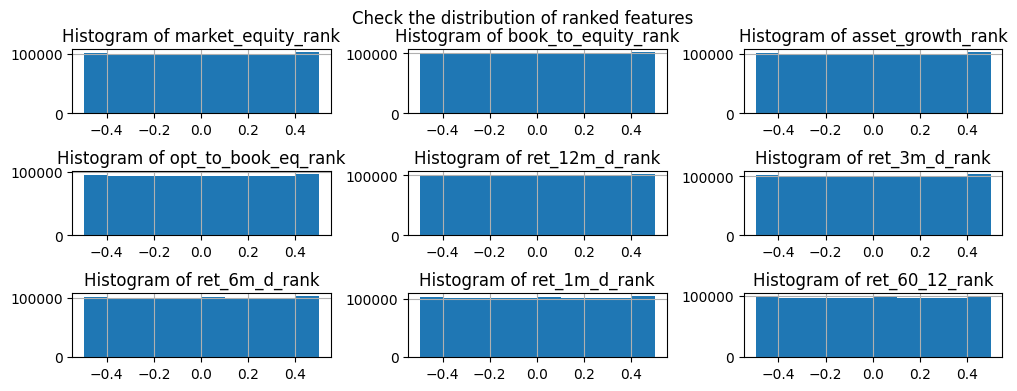

Start parallel running..

Retraining finished:

This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data is bm_model_checkpoint2,                
The trained opt models are ['target_risk', 'max_sharpe'],                
The tested opt models are ['max_sharpe_last_win', 'max_sharpe']

Saving model object..

This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data is bm_model_checkpoint2,                
The trained opt models are ['target_risk', 'max_sharpe'],                
The tested opt models are ['max_sharpe_last_win', 'max_sharpe']


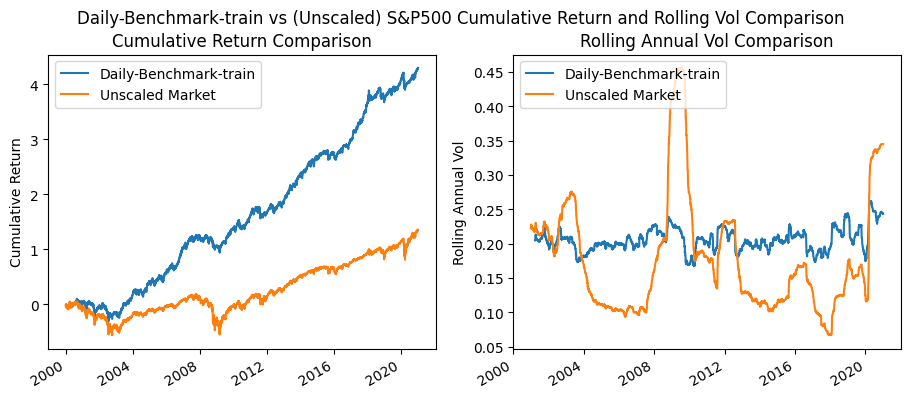

             Daily-Benchmark-train Unscaled Market
avg_rtn_ann               0.207449        0.064591
vol_ann                   0.205632        0.198926
sharpe_ann                1.008834        0.324698
max_drawdown              -0.36327       -0.567754
Elapsed wall-clock time: 754.84 seconds
User CPU time: 560.94 seconds
System CPU time: 146.97 seconds
CPU times: total: 11min 47s
Wall time: 12min 34s


In [51]:
%%time
## Execute the training (including getting data)
data_directory = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/data-used'
# data_directory = r'/home/sagemaker-user/user-default-efs/data-used/'
data_checkpoint_name = 'data_checkpoint4'
start_date = '2000-01-01'
train_end_date = '2020-12-31'

model_directory = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/benchmark_model'
# model_directory = r'/home/sagemaker-user/user-default-efs/benchmark_model/'
model_checkpoint_name = 'bm_model_checkpoint2' # 'bm_model_checkpoint1', 'bm_model_checkpoint2' (full universe); bm_model_checkpoint3 to test sub universe
# get ticker list # IN mod2
with open(f'{data_directory}/top_300_ticker_l.pkl', 'rb') as f:
    top_300_ticker_l = pickle.load(f)

ticker_list = top_300_ticker_l # [] for full universe, top_100_ticker_l, top_200_ticker_l, top_300_ticker_l for top100,200,300 stocks
rebal_freq = 'D' # 'D','W','M'
opt_flag = 'max_sharpe' #'max_sharpe','target_risk'
force_retrain = True
force_take_new_data = True
last_win_only = False

## get data - will get data within the benchmark_run_train
# data_obj = data_unit.data_main(data_directory, data_checkpoint_name, start_date, train_end_date, verbose=False)

## train model - benchmark model
wall_starts = time.time()
process_starts = os.times()

bm_model_obj, train_reg_param_df, train_exp_exc_rtn_df, train_opt_weight_df=\
    benchmark_run_train(data_directory, data_checkpoint_name, start_date, train_end_date,
                         model_directory, model_checkpoint_name,
                         ticker_list, rebal_freq, opt_flag, target_risk=0.2, 
                         force_retrain=force_retrain, force_take_new_data=force_take_new_data,
                         verbose=True)  #IN mod2

## evaluate the trained model
portf_rtn_train, portf_mkt_rtn_train, stats_df_train, scaler_df_train, fig_perf_train, scaled_weight_df_train = \
    bm_model_obj.eval('train',opt_flag, last_win_only, vol_scaler_flag=True, scaling_vol_tgt=0.2, plot_show=True)  #IN mod

process_ends = os.times()
wall_ends = time.time()
print(f"Elapsed wall-clock time: {wall_ends - wall_starts:.2f} seconds")
print(f"User CPU time: {process_ends.user - process_starts.user:.2f} seconds")
print(f"System CPU time: {process_ends.system - process_starts.system:.2f} seconds")

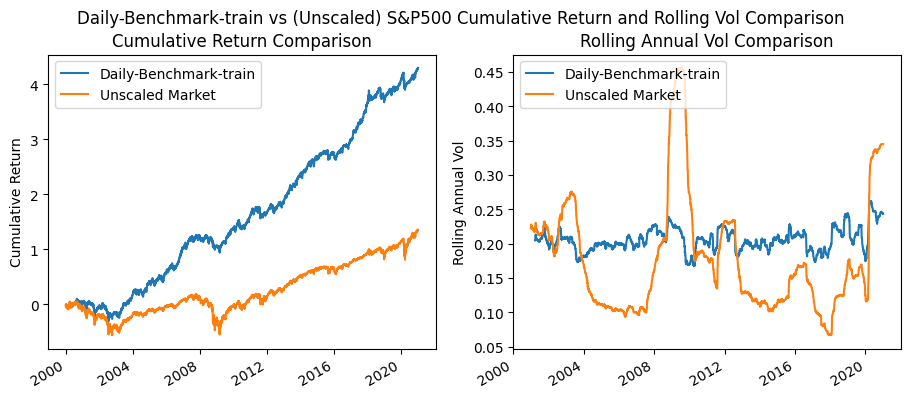

             Daily-Benchmark-train Unscaled Market
avg_rtn_ann               0.207449        0.064591
vol_ann                   0.205632        0.198926
sharpe_ann                1.008834        0.324698
max_drawdown              -0.36327       -0.567754


In [52]:
## evaluate the trained model (could be run seperately if just to adjust for vol scale and produce final results)
portf_rtn_train, portf_mkt_rtn_train, stats_df_train, scaler_df_train, fig_perf_train, scaled_weight_df_train = \
    bm_model_obj.eval('train',opt_flag, last_win_only, vol_scaler_flag=True, scaling_vol_tgt=0.2, plot_show=True)  #IN mod

In [46]:
stats_df_train

,Daily-Benchmark-train,Unscaled Market
avg_rtn_ann,0.2268,0.064591
vol_ann,0.205695,0.198926
sharpe_ann,1.102606,0.324698
max_drawdown,-0.329467,-0.567754


In [110]:
display(bm_model_obj.model_output_dic.keys())
display(bm_model_obj.checkpoint_name)
display(bm_model_obj.rebal_freq)

dict_keys(['train_results_max_sharpe', 'train_results_target_risk', 'test_results_max_sharpe_last_win'])

'bm_model_checkpoint2'

'D'

### Test model:
Given the nature of the benchmark model, the test process is very similar to train process


The checkpoint name of this data is , 
and data_dic keys are []

The checkpoint name of this data is data_checkpoint4, 
and data_dic keys are ['data_useful_info_dic', 'sp500_used', 'mkt_daily', 'train_sp500', 'test_sp500', 'train_mkt', 'test_mkt', 'ticker_permno_dic', 'permno_ticker_dic']

This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data is None,                
The trained opt models are [],                
The tested opt models are []
After loading model..

This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data is bm_model_checkpoint2,                
The trained opt models are ['target_risk', 'max_sharpe'],                
The tested opt models are ['max_sharpe_last_win', 'max_sharpe']

Force training is on:

Saving model object..

The model obj before retraining:

This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data 

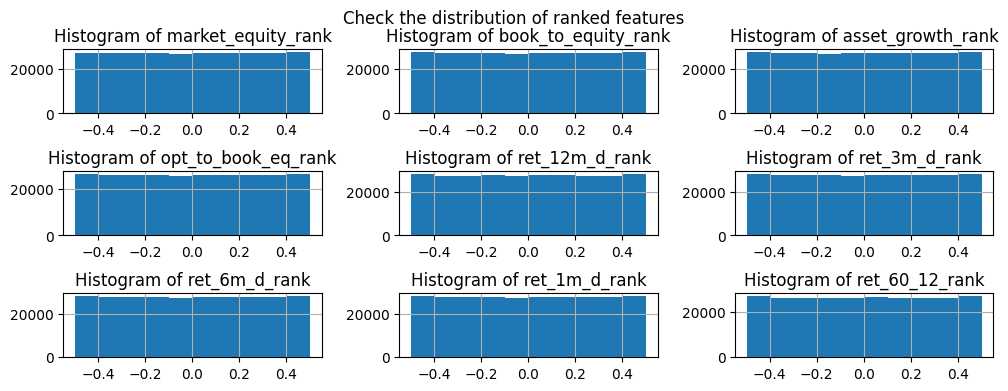

Start parallel running..

Retraining finished:

This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data is bm_model_checkpoint2,                
The trained opt models are ['target_risk', 'max_sharpe'],                
The tested opt models are ['max_sharpe_last_win', 'max_sharpe']

Saving model object..

This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data is bm_model_checkpoint2,                
The trained opt models are ['target_risk', 'max_sharpe'],                
The tested opt models are ['max_sharpe_last_win', 'max_sharpe']


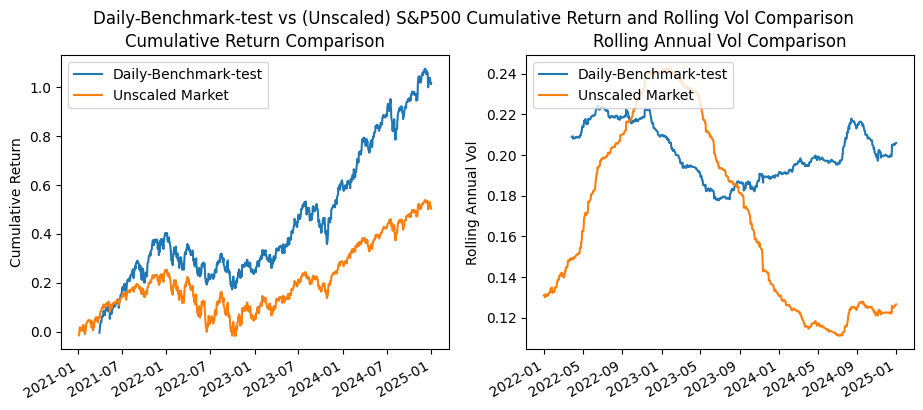

             Daily-Benchmark-test Unscaled Market
avg_rtn_ann               0.27035        0.126089
vol_ann                  0.201593        0.164996
sharpe_ann               1.341063        0.764193
max_drawdown            -0.219846       -0.254251
CPU times: total: 1min
Wall time: 3min 3s


In [53]:
%%time
data_directory = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/data-used'
# data_directory = r'/home/sagemaker-user/user-default-efs/data-used/'
data_checkpoint_name = 'data_checkpoint4'
start_date = '2000-01-01'
train_end_date = '2020-12-31'

model_directory = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/benchmark_model'
model_checkpoint_name = 'bm_model_checkpoint2' #'bm_model_checkpoint2' only bm_model_checkpoint2 works for test with updated test data (full universe); bm_model_checkpoint3 to test sub universe

# get ticker list # IN mod2
with open(f'{data_directory}/top_300_ticker_l.pkl', 'rb') as f:
    top_300_ticker_l = pickle.load(f)

ticker_list = top_300_ticker_l # [] for full universe, or top_100_ticker_l, top_200_ticker_l, top_300_ticker_l
rebal_freq = 'D' # 'D','W','M'
opt_flag = 'max_sharpe' #'max_sharpe','target_risk'
last_win_only = False
force_retrain= True
force_take_new_data = True

## get data - will get data within the benchmark_run_test
# data_obj = data_unit.data_main(data_directory, data_checkpoint_name, start_date, train_end_date, verbose=False)

## test model - benchmark model
bm_model_obj, test_reg_param_df, test_exp_exc_rtn_df, test_opt_weight_df  =\
    benchmark_run_test(data_directory, data_checkpoint_name, start_date, train_end_date,
                         model_directory, model_checkpoint_name,
                         ticker_list, rebal_freq, opt_flag, last_win_only, target_risk=0.2, 
                         force_retrain=force_retrain, 
                         force_take_new_data=force_take_new_data, verbose=True) #IN_mod2

## evaluate the test model
portf_rtn_test, portf_mkt_rtn_test, stats_df_test, scaler_df_test, fig_perf_test, scaled_weight_df_test = \
    bm_model_obj.eval('test', opt_flag, last_win_only, vol_scaler_flag=True, scaling_vol_tgt=0.2, plot_show=True)

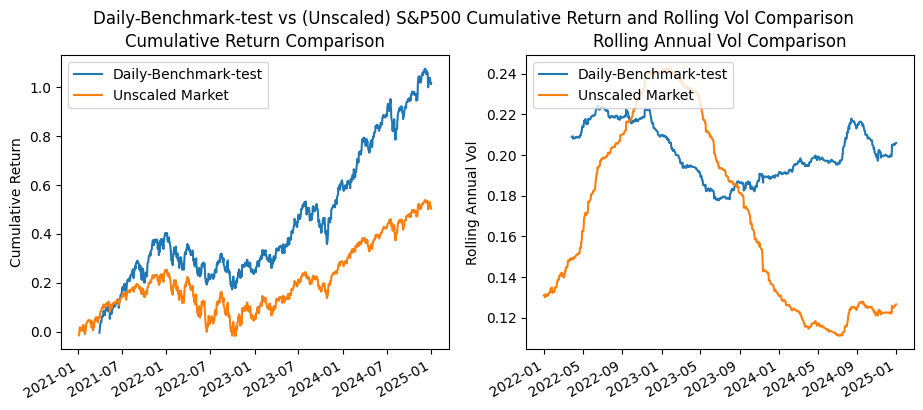

             Daily-Benchmark-test Unscaled Market
avg_rtn_ann               0.27035        0.126089
vol_ann                  0.201593        0.164996
sharpe_ann               1.341063        0.764193
max_drawdown            -0.219846       -0.254251


In [54]:
# the part that produce what live demo needs:
portf_rtn_test, portf_mkt_rtn_test, stats_df_test, scaler_df_test, fig_perf_test, scaled_weight_df_test = \
    bm_model_obj.eval('test', opt_flag, last_win_only, vol_scaler_flag=True, scaling_vol_tgt=0.2, plot_show=True)

,Daily-Benchmark-test,Unscaled Market
avg_rtn_ann,0.27035,0.126089
vol_ann,0.201593,0.164996
sharpe_ann,1.341063,0.764193
max_drawdown,-0.219846,-0.254251


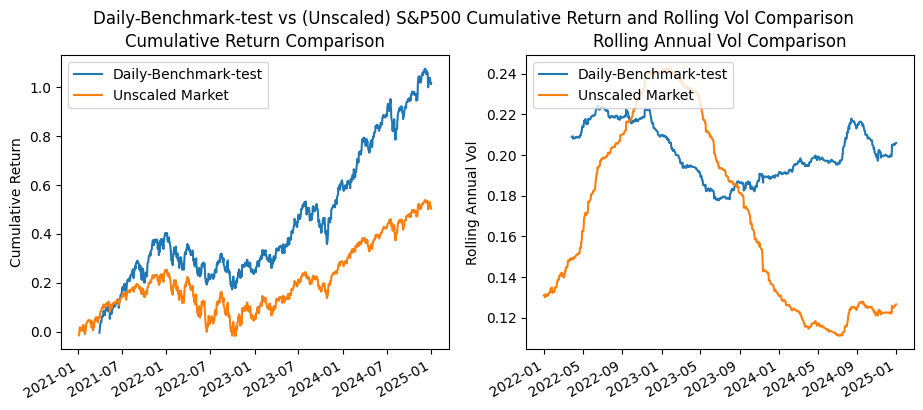

In [55]:
# how to pull the live demo charts and tabel:
display(stats_df_test)
fig_perf_test

In [56]:
# IN check output dtypes
# display(bm_model_obj.dtype)
display(test_reg_param_df.shape)
display(test_reg_param_df.dtypes)
display(test_exp_exc_rtn_df.shape)
display(test_exp_exc_rtn_df.dtypes)
display(test_opt_weight_df.shape)
display(test_opt_weight_df.dtypes)

(985, 10)

const                  float64
market_equity_rank     float64
book_to_equity_rank    float64
asset_growth_rank      float64
opt_to_book_eq_rank    float64
ret_12m_d_rank         float64
ret_3m_d_rank          float64
ret_6m_d_rank          float64
ret_1m_d_rank          float64
ret_60_12_rank         float64
dtype: object

(985, 298)

permno
10104    float64
10107    float64
10145    float64
11308    float64
11403    float64
          ...   
18726    float64
18267    float64
19788    float64
12591    float64
13628    float64
Length: 298, dtype: object

(985, 298)

10104    float64
10107    float64
10145    float64
11308    float64
11403    float64
          ...   
18726    float64
18267    float64
19788    float64
12591    float64
13628    float64
Length: 298, dtype: object

In [33]:
# IN:
display(bm_model_obj)
display(bm_model_obj.model_output_dic.keys())
display(bm_model_obj.opt_tested)


This is a statistical method based bencnmark_model,                 
The model checkpoint name of this data is bm_model_checkpoint2,                
The trained opt models are ['target_risk', 'max_sharpe'],                
The tested opt models are ['max_sharpe_last_win', 'max_sharpe']

dict_keys(['train_results_target_risk', 'test_results_max_sharpe_last_win', 'train_results_max_sharpe', 'test_results_max_sharpe'])

['max_sharpe_last_win', 'max_sharpe']

### Combine Train and Test Key Results (if needed)

In [ ]:
portf_rtn_comb = pd.concat([portf_rtn_train, portf_rtn_test])
portf_mkt_rtn_comb = pd.concat([portf_mkt_rtn_train.rename(columns={'Daily-Benchmark-train':'Daily-Benchmark'})[['Daily-Benchmark', 'Unscaled Market']], \
                                portf_mkt_rtn_test.rename(columns={'Daily-Benchmark-test':'Daily-Benchmark'})[['Daily-Benchmark', 'Unscaled Market']]])
portf_name = 'Daily-Benchmark'

stats_df_comb = pd.DataFrame(columns=portf_mkt_rtn_comb.columns)
stats_df_comb.loc['avg_rtn_ann',:] = portf_mkt_rtn_comb.mean()*252
stats_df_comb.loc['vol_ann',:] = portf_mkt_rtn_comb.std()*np.sqrt(252)
stats_df_comb.loc['sharpe_ann',:] = stats_df_comb.loc['avg_rtn_ann',:]/stats_df_comb.loc['vol_ann',:]
stats_df_comb.loc['max_drawdown', portf_name] = mmd_cal(portf_mkt_rtn_comb, portf_name).iloc[-1]
stats_df_comb.loc['max_drawdown','Unscaled Market'] = mmd_cal(portf_mkt_rtn_comb, 'Unscaled Market').iloc[-1]

stats_df_comb

,Daily-Benchmark,Unscaled Market
avg_rtn_ann,0.217091,0.074418
vol_ann,0.205007,0.193896
sharpe_ann,1.058946,0.383806
max_drawdown,-0.36327,-0.567754


Daily-Benchmark    5.892898
Unscaled Market    1.857211
Name: 2024-12-31 00:00:00, dtype: float64

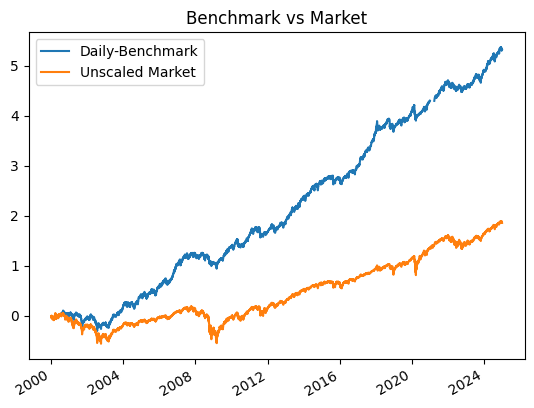

In [58]:
# Quick cum return check (not official chart)
portf_mkt_rtn_comb.cumsum().plot(title='Benchmark vs Market')
portf_mkt_rtn_comb.ffill().cumsum().iloc[-1,:]

### Save Results (if needed)

In [59]:
# save current res
bm_res_dic_test = {
    'portf_rtn':portf_rtn_test, 
    'portf_mkt_rtn': portf_mkt_rtn_test, 
    'stats_df': stats_df_test, 
    'scaler_df': scaler_df_test, 
    # 'fig_perf': fig_perf_test, # take it away given sm can't unpickle due to different plt version 
    'scaled_weight_df': scaled_weight_df_test
}

bm_res_dic_train = {
    'portf_rtn':portf_rtn_train, 
    'portf_mkt_rtn': portf_mkt_rtn_train, 
    'stats_df': stats_df_train, 
    'scaler_df': scaler_df_train, 
    # 'fig_perf': fig_perf_train, 
    'scaled_weight_df': scaled_weight_df_train
}

# prepared train_val + test combine results:
portf_rtn_comb = pd.concat([portf_rtn_train, portf_rtn_test])
portf_mkt_rtn_comb = pd.concat([portf_mkt_rtn_train.rename(columns={'Daily-Benchmark-train':'Daily-Benchmark'})[['Daily-Benchmark', 'Unscaled Market']], \
                                portf_mkt_rtn_test.rename(columns={'Daily-Benchmark-test':'Daily-Benchmark'})[['Daily-Benchmark', 'Unscaled Market']]])
portf_name = 'Daily-Benchmark'

stats_df_comb = pd.DataFrame(columns=portf_mkt_rtn_comb.columns)
stats_df_comb.loc['avg_rtn_ann',:] = portf_mkt_rtn_comb.mean()*252
stats_df_comb.loc['vol_ann',:] = portf_mkt_rtn_comb.std()*np.sqrt(252)
stats_df_comb.loc['sharpe_ann',:] = stats_df_comb.loc['avg_rtn_ann',:]/stats_df_comb.loc['vol_ann',:]
stats_df_comb.loc['max_drawdown', portf_name] = mmd_cal(portf_mkt_rtn_comb, portf_name).iloc[-1]
stats_df_comb.loc['max_drawdown','Unscaled Market'] = mmd_cal(portf_mkt_rtn_comb, 'Unscaled Market').iloc[-1]

scaler_df_comb = pd.concat([scaler_df_train, scaler_df_test]).ffill()
scaled_weight_df_comb = pd.concat([scaled_weight_df_train, scaled_weight_df_test])

bm_res_dic_comb = {
    'portf_rtn':portf_rtn_comb, 
    'portf_mkt_rtn': portf_mkt_rtn_comb, 
    'stats_df': stats_df_comb, 
    'scaler_df': scaler_df_comb, 
    # 'fig_perf': fig_perf_train, 
    'scaled_weight_df': scaled_weight_df_comb
}

# save_path = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN\pres2_model_res/'
save_path = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN\pres3_model_res/'
universe_label = 'top300' # top300, top200, top100, full
with open(f'{save_path}/bm_res_dic_test_{universe_label}.pkl', 'wb') as f:
    pickle.dump(bm_res_dic_test, f)

with open(f'{save_path}/bm_res_dic_train_{universe_label}.pkl', 'wb') as f:
    pickle.dump(bm_res_dic_train, f)

with open(f'{save_path}/bm_res_dic_comb_{universe_label}.pkl', 'wb') as f:
    pickle.dump(bm_res_dic_comb, f)
 

In [68]:
# save again for EG
# save_path_2 = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN\pres3_model_res/bm_top300_0.2'
# with open(f'{save_path_2}/portf_rtn_comb.pkl', 'wb') as f:
#     pickle.dump(portf_rtn_comb, f)

with open(f'{save_path}/bm_res_dic_comb_top200.pkl', 'rb') as f:
    bm_res_dic_comb_200 = pickle.load(f)

portf_rtn_comb_200 = bm_res_dic_comb_200['portf_rtn']
save_path_2 = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN\pres3_model_res/bm_top200_0.2'
with open(f'{save_path_2}/portf_rtn_comb.pkl', 'wb') as f:
    pickle.dump(portf_rtn_comb_200, f)

In [ ]:
# # modify partial of the model - manual
# del test_obj.model_output_dic['test_results_max_sharpe_last_win']
# del test_obj.model_output_dic['test_results_target_risk_last_win']
# test_obj.opt_tested.remove('max_sharpe')
# test_obj.opt_tested.remove('target_risk')

# with open(f'{model_directory}/{model_checkpoint_name}/bm_model_obj_D.pkl', 'wb') as f:
#     pickle.dump(test_obj, f)

## Execution outside of classes

In [73]:
# Get data
data_directory = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/data-used'
data_checkpoint_name = 'data_checkpoint1'  # 'data_checkpoint1'
start_date = '2000-01-01'
train_end_date = '2020-12-31'

data_obj = data_unit.data_main(data_directory, data_checkpoint_name, start_date, train_end_date, verbose=False)

# Get data from the object
sp500_used = data_obj.data_dic['sp500_used']
train_sp500 = data_obj.data_dic['train_sp500']
test_sp500 = data_obj.data_dic['test_sp500']
train_mkt = data_obj.data_dic['train_mkt']
test_mkt = data_obj.data_dic['test_mkt']
data_useful_info_dic = data_obj.data_dic['data_useful_info_dic']

display(data_useful_info_dic.keys())

# ticker- permno map (this step is moved to data level)
# multi_index = train_sp500.set_index(['ticker','permno']).index.unique()
# ticker_permno_dic = {item[0]:item[1] for item in multi_index}
# permno_ticker_dic = {item[1]:item[0] for item in multi_index}


The checkpoint name of this data is , 
and data_dic keys are []

The checkpoint name of this data is data_checkpoint1, 
and data_dic keys are ['data_useful_info_dic', 'sp500_used', 'mkt_daily', 'train_sp500', 'test_sp500', 'train_mkt', 'test_mkt', 'ticker_permno_dic', 'permno_ticker_dic']


dict_keys(['useful_columns_raw', 'name_map', 'time_columns', 'identifier_columns', 'categorical_columns', 'numerical_columns'])

In [74]:
# specify universe
ticker_list = []

# prepare features
# sel_features = ['market_equity','book_to_equity','asset_growth','opt_to_book_eq','ret_12m_d']
sel_features = ['market_equity','book_to_equity','asset_growth','opt_to_book_eq','ret_12m_d', 'ret_1m_d', 'ret_3m_d', 'ret_6m_d'] + ['ret_60_12'] #IN: haven't tried 60_12 in this setting
sel_tgt = ['return']

# prepare model used data
train_used = train_sp500[['date','permno','ticker']+sel_features+sel_tgt]
test_used = test_sp500[['date','permno','ticker']+sel_features+sel_tgt]

if len(ticker_list)!=0:
    train_used = train_used[train_used['ticker'].isin(ticker_list)]
    test_used = test_used[test_used['ticker'].isin(ticker_list)]

# further adjustment on return based feature by filling the first year data with ret_12_1 (monthly)
# if 'ret_12m_d' in sel_features:
#     train_used.loc[train_used['date']<'2000-12-29', 'ret_12m_d'] = train_sp500.loc[train_used['date']<'2000-12-29', 'ret_12_1']

ret_feat_map = {'ret_12m_d':'ret_12_1', 'ret_6m_d':'ret_6_1', 'ret_3m_d':'ret_3_1', 'ret_1m_d':'ret_1_0'}
for col in ['ret_12m_d', 'ret_1m_d', 'ret_3m_d', 'ret_6m_d']:
    if col in sel_features:
        train_used.loc[train_used['date']<'2000-12-29', col] = \
            train_used.loc[train_used['date']<'2000-12-29', col].fillna(train_sp500.loc[train_used['date']<'2000-12-29', ret_feat_map[col]])

# prepare a column called previous period excess return for factor return regression later
# add mkt return to the data
print (f'The shape of train_used before adding return_sp and excess return is {train_used.shape}')
train_used = pd.merge(train_used, train_mkt.reset_index()[['Date','return_sp']].rename(columns={'Date':'date'}),
                      on=['date'], how='left')
train_used['excess_ret'] = train_used['return']-train_used['return_sp']
print (f'The shape of train_used after adding return_sp and excess return is {train_used.shape}')

prev_d_exc_ret_df = train_used.set_index('date').groupby('permno')['excess_ret']\
    .apply(lambda x: x.shift()).rename('prev_d_exc_ret').reset_index()
# this is the same as:
# train_used.set_index(['date', 'permno']).groupby('permno')['return'].apply(lambda x: x.shift().droplevel(0)).rename('prev_d_ret').reset_index()

print (f'The shape of train_used before adding prev_d_exc_ret is {train_used.shape}')
train_used = pd.merge(train_used, prev_d_exc_ret_df, on=['date','permno'], how='left')
print (f'The shape of train_used before adding prev_d_exc_ret is {train_used.shape}')

# do the same for test_used
test_used = pd.merge(test_used, test_mkt.reset_index()[['Date','return_sp']].rename(columns={'Date':'date'}),
                      on=['date'], how='left')
test_used['excess_ret'] = test_used['return']-test_used['return_sp']

prev_d_exc_ret_df_test = test_used.set_index('date').groupby('permno')['excess_ret']\
    .apply(lambda x: x.shift()).rename('prev_d_exc_ret').reset_index()

test_used = pd.merge(test_used, prev_d_exc_ret_df_test, on=['date','permno'], how='left')


The shape of train_used before adding return_sp and excess return is (2641874, 13)
The shape of train_used after adding return_sp and excess return is (2641874, 15)
The shape of train_used before adding prev_d_exc_ret is (2641874, 15)
The shape of train_used before adding prev_d_exc_ret is (2641874, 16)


In [75]:
print (f'The shape of train_used before adding rank_features is {train_used.shape}')
train_used, sel_features_adj = prep_rank_feature(train_used, sel_features, shift_d=1)
print (f'The shape of train_used after adding rank_features is {train_used.shape}')
print (f'The added columns are: {sel_features_adj}')

# do the same for test_used
test_used, sel_features_adj_test = prep_rank_feature(test_used, sel_features, shift_d=1)

The shape of train_used before adding rank_features is (2641874, 16)
The shape of train_used after adding rank_features is (2641874, 25)
The added columns are: ['market_equity_rank', 'book_to_equity_rank', 'asset_growth_rank', 'opt_to_book_eq_rank', 'ret_12m_d_rank', 'ret_1m_d_rank', 'ret_3m_d_rank', 'ret_6m_d_rank', 'ret_60_12_rank']


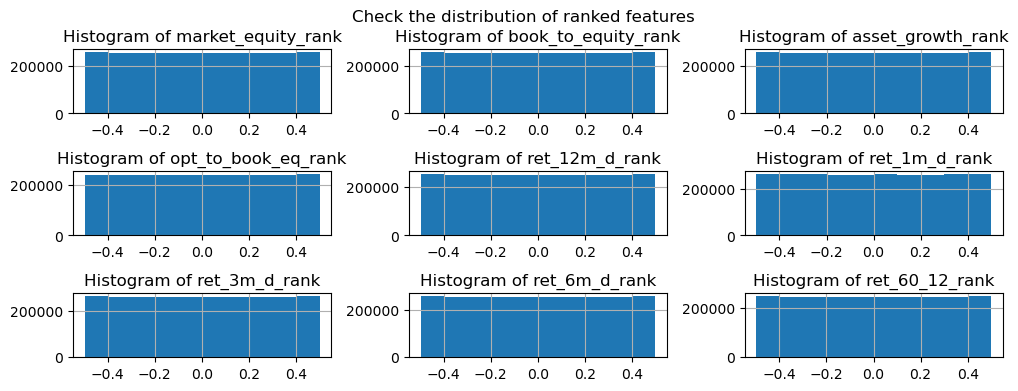

In [76]:
# Check the distribution of the ranked and shifted signals
n = len(sel_features_adj)
n_per_row=3
if n%n_per_row==0:
    n_rows = n//n_per_row
else:
    n_rows = n//n_per_row+1
fig1, ax1 = plt.subplots(n_rows, n_per_row, figsize=(12,4))
for i, col in enumerate(sel_features_adj):
    train_used[col].to_frame().hist(ax=ax1[i//n_per_row, i%n_per_row])
    ax1[i//n_per_row, i%n_per_row].set_title(f'Histogram of {col}')
plt.suptitle('Check the distribution of ranked features')
plt.subplots_adjust(hspace=0.9)
plt.show()

### Use rolling regression way to decide factor weight and then use optimizer to decide portflio weight

#### For loop implementation

In [86]:
# use dataframes to record rolling regression and optimization results
reg_param_df = pd.DataFrame(columns=['const']+sel_features_adj)
pred_df = pd.DataFrame()
opt_weight_df = pd.DataFrame()
n_multiple = 252 # IN: number of period per ann
rebal_freq = 'M' # IN: 'D', 'W', 'M'
opt_flag = 'max_sharpe'  #IN: 'target_risk' or 'max_sharpe'
target_risk = 0.2  #IN: this is an example of 20% annual portfolio risk
input_used = test_used # train_used, test_used

# dates_train_daily = train_used['date'].unique()[20:] # the first available date for features is the first date of the second month of all data
dates_train_daily = input_used['date'].unique()[20:] # the first available date for features is the first date of the second month of all data
dates_train_weekly = pd.Series(np.ones(len(dates_train_daily)), \
                               index=pd.DatetimeIndex(dates_train_daily)).asfreq('W-WED').index
dates_train_monthly = pd.Series(np.ones(len(dates_train_daily)), \
                                index=pd.DatetimeIndex(dates_train_daily)).asfreq('ME').index

if rebal_freq == 'D':
    rebal_dates = dates_train_daily
    # period_d =1
elif rebal_freq == 'W':
    rebal_dates = dates_train_weekly
    # period_d =5
elif rebal_freq == 'M':
    rebal_dates = dates_train_monthly
    # period_d =21

for i, date in enumerate(rebal_dates):
    print (date)
    ''' regression (for factor weights and next period exp return)'''

    index_in_daily_dates = list(dates_train_daily).index(dates_train_daily[dates_train_daily<=date][-1])

    date_period = dates_train_daily[max(0,(index_in_daily_dates+1)-252*1)
                                :max(252*1, (index_in_daily_dates+1))]
    data_t = input_used[input_used['date'].isin(date_period)]

    df_y = data_t['excess_ret']
    df_x = data_t[sel_features_adj].apply(lambda x: x*data_t['prev_d_exc_ret'], axis=0).ffill()
    x, y, sm_model, model_prefit, param_reg \
        = regression_sm(df_y, df_x)
    
    pred_t = pd.concat([data_t[['date','permno']], sm_model.predict(x).rename('pred_exc_ret')], axis=1).dropna()
    pred_df = pd.concat([pred_df, pred_t], axis=0)
    reg_param_df.loc[date,:] = param_reg

    ''' optimization'''
    if rebal_freq == 'M':
        match_date = dates_train_daily[(dates_train_daily.month==date.month)
                                       &(dates_train_daily.year==date.year)][-1]
        
        exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
            .apply(lambda x: x.loc[x['date']==match_date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)
    elif rebal_freq == 'W':
        match_date = dates_train_daily[(dates_train_daily<=date)][-1]
        
        exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
            .apply(lambda x: x.loc[x['date']==match_date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)        
    else:
        exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
            .apply(lambda x: x.loc[x['date']==date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)

    # prepare cov for optimizer 
    # IN: rationale: 
    # a) use current lookback period's data
    # b) based on JPM paper (1) use LedoitWolf() method to regulate the cov matrix, (2) check positive semi-definite conditions and fix it if needed
    return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
        .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[exp_exc_rtn.index].replace(np.nan, 0)
    cov_matrix = risk_models.fix_nonpositive_semidefinite(
        pd.DataFrame(LedoitWolf().fit(return_data).covariance_, 
                 index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral') 
    # fix_method: {"spectral", "diag"}, defaults to "spectral"

    ## alternative method-1
    # cov_matrix = risk_models.fix_nonpositive_semidefinite(return_data.cov().replace(np.nan,0)*n_multiple, fix_method='diag')

    ## alternative method-2
    # vol_vector = return_data.std()
    # corr_df = return_data.corr()
    # cov_matrix = risk_models.sample_cov(
    #     pd.DataFrame(np.diag(vol_vector).dot(corr_df).dot(np.diag(vol_vector)), 
    #                  index=vol_vector.index, columns=vol_vector.index), frequency = 252)

    opt_w_ef = optimizer_ef(exp_exc_rtn*n_multiple, cov_matrix, opt_flag, target_risk, 
                 solver_name='CLARABEL', market_neutral=False)
    
    opt_w_t = pd.DataFrame(opt_w_ef, index=[date])
    opt_weight_df = pd.concat([opt_weight_df, opt_w_t])

2021-02-28 00:00:00
2021-03-31 00:00:00
2021-04-30 00:00:00
2021-05-31 00:00:00
2021-06-30 00:00:00
2021-07-31 00:00:00
2021-08-31 00:00:00
2021-09-30 00:00:00
2021-10-31 00:00:00
2021-11-30 00:00:00
2021-12-31 00:00:00
2022-01-31 00:00:00
2022-02-28 00:00:00
2022-03-31 00:00:00
2022-04-30 00:00:00
2022-05-31 00:00:00
2022-06-30 00:00:00
2022-07-31 00:00:00
2022-08-31 00:00:00
2022-09-30 00:00:00
2022-10-31 00:00:00
2022-11-30 00:00:00
2022-12-31 00:00:00
2023-01-31 00:00:00
2023-02-28 00:00:00
2023-03-31 00:00:00
2023-04-30 00:00:00
2023-05-31 00:00:00
2023-06-30 00:00:00
2023-07-31 00:00:00
2023-08-31 00:00:00
2023-09-30 00:00:00
2023-10-31 00:00:00
2023-11-30 00:00:00
2023-12-31 00:00:00
2024-01-31 00:00:00
2024-02-29 00:00:00
2024-03-31 00:00:00
2024-04-30 00:00:00
2024-05-31 00:00:00
2024-06-30 00:00:00
2024-07-31 00:00:00
2024-08-31 00:00:00
2024-09-30 00:00:00
2024-10-31 00:00:00
2024-11-30 00:00:00
2024-12-31 00:00:00


In [87]:
# one day:
date = pd.to_datetime('2024-01-31')
rebal_freq = 'D'
print (date)
''' regression (for factor weights and next period exp return)'''

index_in_daily_dates = list(dates_train_daily).index(dates_train_daily[dates_train_daily<=date][-1])

date_period = dates_train_daily[max(0,(index_in_daily_dates+1)-252*1)
                            :max(252*1, (index_in_daily_dates+1))]
data_t = input_used[input_used['date'].isin(date_period)]

df_y = data_t['excess_ret']
df_x = data_t[sel_features_adj].apply(lambda x: x*data_t['prev_d_exc_ret'], axis=0).ffill()
x, y, sm_model, model_prefit, param_reg \
    = regression_sm(df_y, df_x)

pred_t = pd.concat([data_t[['date','permno']], sm_model.predict(x).rename('pred_exc_ret')], axis=1).dropna()
pred_df = pd.concat([pred_df, pred_t], axis=0)
reg_param_df.loc[date,:] = param_reg

''' optimization'''
if rebal_freq == 'M':
    match_date = dates_train_daily[(dates_train_daily.month==date.month)
                                    &(dates_train_daily.year==date.year)][-1]
    
    exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
        .apply(lambda x: x.loc[x['date']==match_date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)
elif rebal_freq == 'W':
    match_date = dates_train_daily[(dates_train_daily<=date)][-1]
    
    exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
        .apply(lambda x: x.loc[x['date']==match_date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)        
else:
    exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
        .apply(lambda x: x.loc[x['date']==date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)

# prepare cov for optimizer 
# IN: rationale: 
# a) use current lookback period's data
# b) based on JPM paper (1) use LedoitWolf() method to regulate the cov matrix, (2) check positive semi-definite conditions and fix it if needed
return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
    .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[exp_exc_rtn.index].replace(np.nan, 0)
cov_matrix = risk_models.fix_nonpositive_semidefinite(
    pd.DataFrame(LedoitWolf().fit(return_data).covariance_, 
                index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral') 
# fix_method: {"spectral", "diag"}, defaults to "spectral"

## alternative method-1
# cov_matrix = risk_models.fix_nonpositive_semidefinite(return_data.cov().replace(np.nan,0)*n_multiple, fix_method='diag')

## alternative method-2
# vol_vector = return_data.std()
# corr_df = return_data.corr()
# cov_matrix = risk_models.sample_cov(
#     pd.DataFrame(np.diag(vol_vector).dot(corr_df).dot(np.diag(vol_vector)), 
#                  index=vol_vector.index, columns=vol_vector.index), frequency = 252)

opt_w_ef = optimizer_ef(exp_exc_rtn*n_multiple, cov_matrix, opt_flag, target_risk, 
                solver_name='CLARABEL', market_neutral=False)

opt_w_t = pd.DataFrame(opt_w_ef, index=[date])
opt_weight_df = pd.concat([opt_weight_df, opt_w_t])

2024-01-31 00:00:00


In [43]:
# # data checking when needed
# data_t.dtypes
# df_x.isnull().sum()

#### Parallel implementation

In [88]:
# use dataframes to record rolling regression and optimization results
# reg_param_df = pd.DataFrame(columns=['const']+sel_features_adj)
# pred_df = pd.DataFrame()
# opt_weight_df = pd.DataFrame()
n_multiple = 252 # IN: number of period per ann
rebal_freq = 'M' # IN: 'D', 'W', 'M'
opt_flag = 'max_sharpe'  #IN: 'target_risk' or 'max_sharpe'
target_risk = 0.2  #IN: this is an example of 20% annual portfolio risk
rolling_ana_data_used = test_used # train_used, test_used

dates_train_daily = rolling_ana_data_used['date'].unique()[20:] # the first available date for features is the first date of the second month of all data
dates_train_weekly = pd.Series(np.ones(len(dates_train_daily)), \
                               index=pd.DatetimeIndex(dates_train_daily)).asfreq('W-WED').index
dates_train_monthly = pd.Series(np.ones(len(dates_train_daily)), \
                                index=pd.DatetimeIndex(dates_train_daily)).asfreq('ME').index

if rebal_freq == 'D':
    rebal_dates = dates_train_daily
    # period_d =1
elif rebal_freq == 'W':
    rebal_dates = dates_train_weekly
    # period_d =5
elif rebal_freq == 'M':
    rebal_dates = dates_train_monthly
    # period_d =21

def regression_n_opt_t(date, dates_train_daily, rolling_ana_data_used, opt_flag, target_risk):
    ''' regression (for factor weights and next period exp return)'''

    index_in_daily_dates = list(dates_train_daily).index(dates_train_daily[dates_train_daily<=date][-1])

    date_period = dates_train_daily[max(0,(index_in_daily_dates+1)-252*1)
                                :max(252*1, (index_in_daily_dates+1))]
    data_t = rolling_ana_data_used[rolling_ana_data_used['date'].isin(date_period)]

    df_y = data_t['excess_ret']
    df_x = data_t[sel_features_adj].apply(lambda x: x*data_t['prev_d_exc_ret'], axis=0).ffill()
    x, y, sm_model, model_prefit, param_reg \
        = regression_sm(df_y, df_x)
    
    pred_t = pd.concat([data_t[['date','permno']], sm_model.predict(x).rename('pred_exc_ret')], axis=1)
    # pred_df = pd.concat([pred_df, pred_t], axis=0)
    # reg_param_df.loc[date,:] = param_reg
    param_reg_t = pd.DataFrame(param_reg.values, columns=[date], index=param_reg.index).T

    ''' optimization'''
    if rebal_freq == 'M':
        match_date = dates_train_daily[(dates_train_daily.month==date.month)
                                       &(dates_train_daily.year==date.year)][-1]
        
        exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
            .apply(lambda x: x.loc[x['date']==match_date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)
    elif rebal_freq == 'W':
        match_date = dates_train_daily[(dates_train_daily<=date)][-1]
        
        exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
            .apply(lambda x: x.loc[x['date']==match_date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)        
    else:
        exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']]\
            .apply(lambda x: x.loc[x['date']==date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)
        
    exp_exc_rtn_t = pd.DataFrame(exp_exc_rtn.values, columns=[date], index=exp_exc_rtn.index).T
    
    # prepare cov for optimizer 
    # IN: rationale: 
    # a) use current lookback period's data
    # b) based on JPM paper (1) use LedoitWolf() method to regulate the cov matrix, (2) check positive semi-definite conditions and fix it if needed
    return_data = data_t[['date','permno']+['prev_d_exc_ret']]\
        .groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[exp_exc_rtn.index].replace(np.nan, 0)
    cov_matrix = risk_models.fix_nonpositive_semidefinite(
        pd.DataFrame(LedoitWolf().fit(return_data).covariance_, 
                 index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral') 
    # fix_method: {"spectral", "diag"}, defaults to "spectral"

    opt_w_ef = optimizer_ef(exp_exc_rtn*n_multiple, cov_matrix, opt_flag, target_risk, 
                 solver_name='CLARABEL', market_neutral=False)
    
    opt_w_t = pd.DataFrame(opt_w_ef, index=[date])

    return param_reg_t, exp_exc_rtn_t, opt_w_t

# Run in parallel
## IN: note the results from the parallel processing has to be just one list of result at each t, which could be a tuple of different results at each time t
res_list = Parallel(n_jobs=-1)(delayed(
    regression_n_opt_t)(date, dates_train_daily, rolling_ana_data_used, opt_flag, target_risk)
    for date in rebal_dates
)

# Organize the results
reg_param_df = pd.concat([res_t[0] for res_t in res_list])
exp_exc_rtn_df = pd.concat([res_t[1] for res_t in res_list])
opt_weight_df = pd.concat([res_t[2] for res_t in res_list])


In [89]:
display(reg_param_df.shape)
display(exp_exc_rtn_df.shape)
display(opt_weight_df.shape)


(47, 10)

(47, 564)

(47, 564)

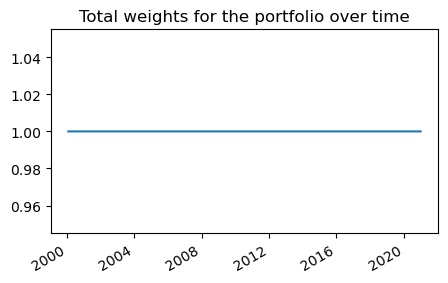

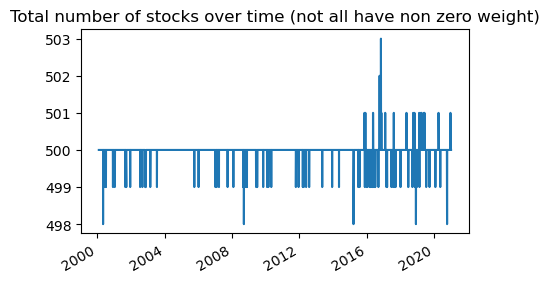

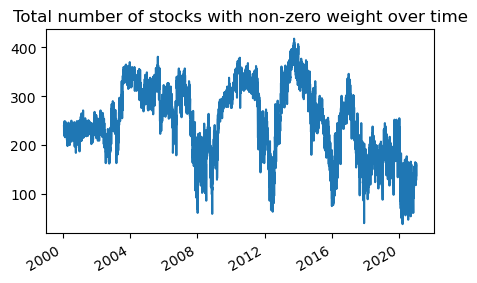

In [762]:
# check basic properties for optimization weights:
np.round(opt_weight_df.sum(axis=1),2).plot(title='Total weights for the portfolio over time', figsize=(5,3))
plt.show()

opt_weight_df.count(axis=1).plot(title='Total number of stocks over time (not all have non zero weight)', figsize=(5,3))
plt.show()

opt_weight_df[opt_weight_df>0].count(axis=1).plot(title='Total number of stocks with non-zero weight over time', figsize=(5,3))
plt.show()

In [764]:
train_sp500.columns

Index(['permno', 'date', 'company_name', 'ncusip', 'ticker', 'gvkey',
       'industry_code', 'return', 'volume', 'return_lead1m', 'market_equity',
       'book_to_equity', 'asset_growth', 'ret_12_1', 'ret_6_1', 'ret_3_1',
       'ret_60_12', 'ret_1_0', 'ret_12m_d', 'ret_6m_d', 'ret_3m_d', 'ret_1m_d',
       'opt_to_book_eq'],
      dtype='object')

## Recording the performances - different versions

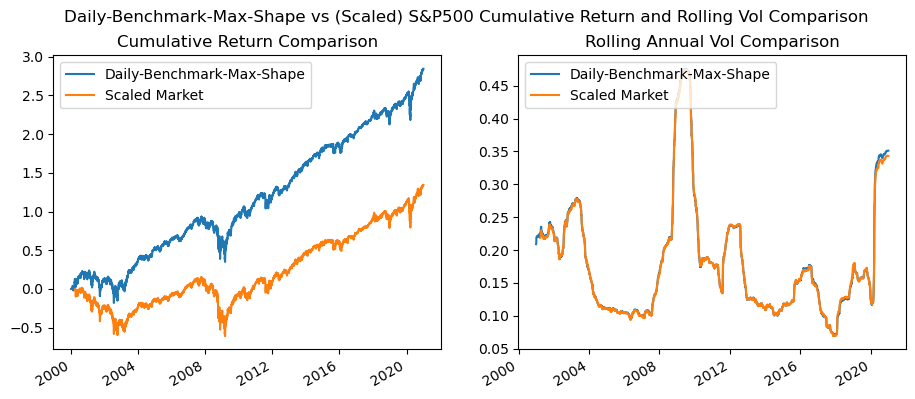

             Daily-Benchmark-Max-Shape Scaled Market
avg_rtn_ann                   0.135699      0.064856
vol_ann                       0.202689      0.201579
sharpe_ann                    0.669494      0.321741
max_drawdown                 -0.502374      -0.58201


In [ ]:
# check model performance - max-sharp daily rebal performance - training
# portf_rtn, portf_mkt_rtn, stats_df = \
#     portfolio_performance(train_used, opt_weight_df, 'Daily-Benchmark-Max-Sharpe', 'D', train_mkt)

train_used_obj = bm_model_obj.train_used
train_mkt_obj = bm_model_obj.input_data_obj.data_dic['train_mkt']
opt_weight_df_obj = bm_model_obj.model_output_dic['train_results_max_sharpe']['opt_weight_df']

# portf_rtn, portf_mkt_rtn, stats_df = \
#     portfolio_performance(train_used_obj, opt_weight_df_obj, 'Daily-Benchmark-Max-Shape', 'D', train_mkt_obj)

portf_rtn, portf_mkt_rtn, stats_df, scaler_df = \
    portfolio_performance(train_used_obj, opt_weight_df_obj, 'Daily-Benchmark-Max-Shape', 'D', train_mkt_obj, vol_scaler_flag=False, scaling_vol_tgt=0.3)

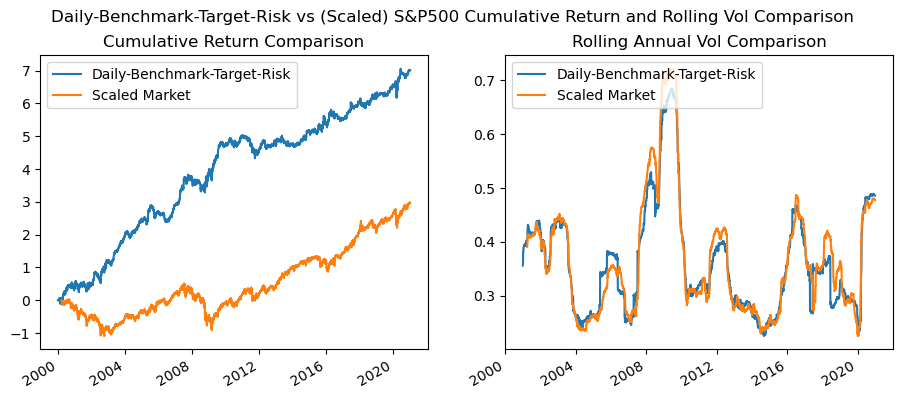

             Daily-Benchmark-Target-Risk Scaled Market
avg_rtn_ann                     0.333992      0.143764
vol_ann                         0.374301      0.382246
sharpe_ann                      0.892308      0.376102
max_drawdown                   -0.527704     -0.832279


In [ ]:
# check model performance - target risk daily rebal performance - training
train_used_obj = bm_model_obj.train_used
train_mkt_obj = bm_model_obj.input_data_obj.data_dic['train_mkt']
opt_weight_df_obj = bm_model_obj.model_output_dic['train_results_target_risk']['opt_weight_df']

# portf_rtn, portf_mkt_rtn, stats_df = \
#     portfolio_performance(train_used_obj, opt_weight_df_obj, 'Daily-Benchmark-Target-Risk', 'D', train_mkt_obj)

portf_rtn, portf_mkt_rtn, stats_df, scaler_df = \
    portfolio_performance(train_used_obj, opt_weight_df_obj, 'Daily-Benchmark-Target-Risk', 'D', train_mkt_obj, vol_scaler_flag=False, scaling_vol_tgt=0.3)

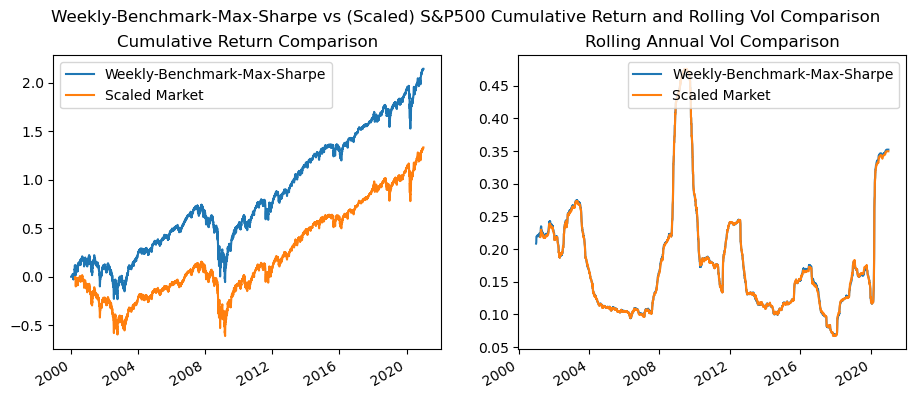

             Weekly-Benchmark-Max-Sharpe Scaled Market
avg_rtn_ann                     0.102099       0.06423
vol_ann                         0.203006      0.202446
sharpe_ann                      0.502939      0.317268
max_drawdown                   -0.597393      -0.58464


In [ ]:
# check model performance - max-sharp weekly rebal performance - training
train_used_obj = bm_model_obj.train_used
train_mkt_obj = bm_model_obj.input_data_obj.data_dic['train_mkt']
opt_weight_df_obj = bm_model_obj.model_output_dic['train_results_max_sharpe']['opt_weight_df']

# portf_rtn, portf_mkt_rtn, stats_df = \
#     portfolio_performance(train_used_obj, opt_weight_df_obj, 'Weekly-Benchmark-Max-Sharpe', 'W', train_mkt_obj)

portf_rtn, portf_mkt_rtn, stats_df, scaler_df = \
    portfolio_performance(train_used_obj, opt_weight_df_obj, 'Weekly-Benchmark-Max-Sharpe', 'W', train_mkt_obj, vol_scaler_flag=False, scaling_vol_tgt=0.3)

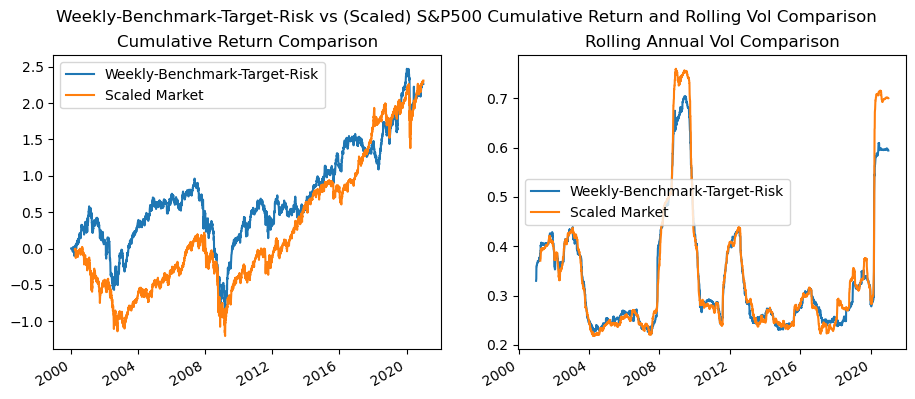

             Weekly-Benchmark-Target-Risk Scaled Market
avg_rtn_ann                      0.108028      0.111413
vol_ann                          0.357565      0.372679
sharpe_ann                       0.302122      0.298953
max_drawdown                    -0.890549     -0.853656


In [ ]:
# check model performance - target risk weekly rebal performance - training
train_used_obj = bm_model_obj.train_used
train_mkt_obj = bm_model_obj.input_data_obj.data_dic['train_mkt']
opt_weight_df_obj = bm_model_obj.model_output_dic['train_results_target_risk']['opt_weight_df']

# portf_rtn, portf_mkt_rtn, stats_df = \
#     portfolio_performance(train_used_obj, opt_weight_df_obj, 'Weekly-Benchmark-Target-Risk', 'W', train_mkt_obj)

portf_rtn, portf_mkt_rtn, stats_df, scaler_df = \
    portfolio_performance(train_used_obj, opt_weight_df_obj, 'Weekly-Benchmark-Target-Risk', 'W', train_mkt_obj, vol_scaler_flag=False, scaling_vol_tgt=0.3)

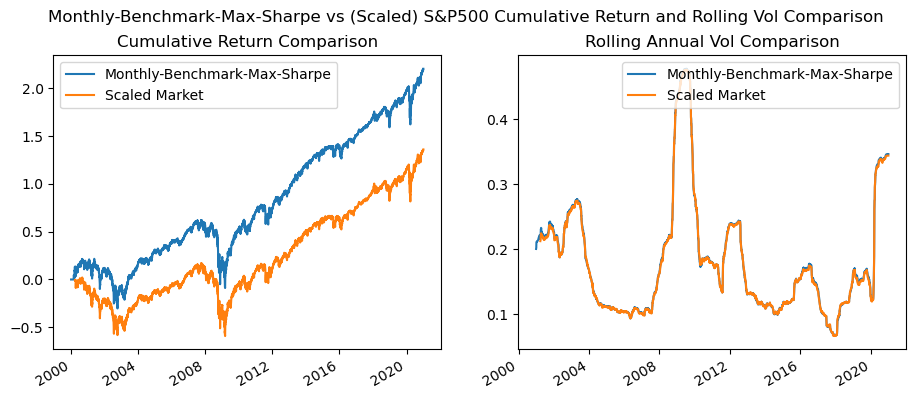

             Monthly-Benchmark-Max-Sharpe Scaled Market
avg_rtn_ann                      0.105077      0.065585
vol_ann                          0.202313       0.20135
sharpe_ann                        0.51938      0.325728
max_drawdown                    -0.561888     -0.583192


In [ ]:
# with revised perf function - check model performance - max-sharp monthly rebal performance - training
# portf_rtn, portf_mkt_rtn, stats_df = \
#     portfolio_performance(train_used, opt_weight_df, 'Monthly-Benchmark-Max-Sharpe', 'M', train_mkt['return_sp'])

portf_rtn, portf_mkt_rtn, stats_df, scaler_df = \
    portfolio_performance(train_used, opt_weight_df, 'Monthly-Weekly-Benchmark-Max-Sharpe', 'M', 
                          train_mkt, vol_scaler_flag=False, scaling_vol_tgt=0.3)

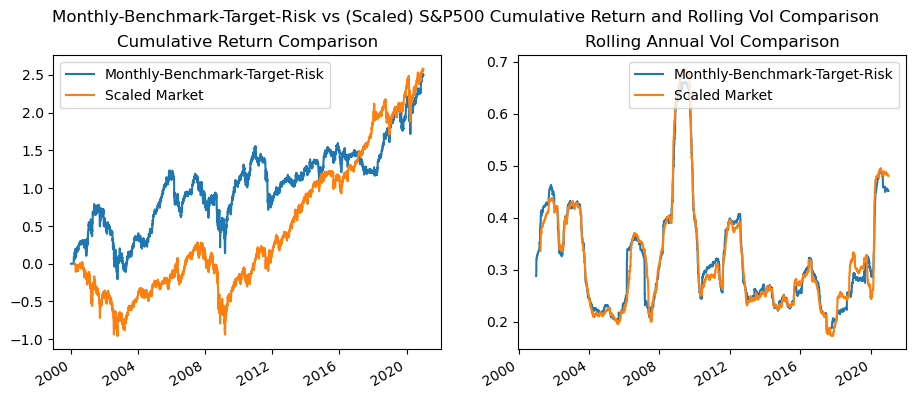

             Monthly-Benchmark-Target-Risk Scaled Market
avg_rtn_ann                       0.118852       0.12439
vol_ann                           0.336297       0.33805
sharpe_ann                        0.353414      0.367962
max_drawdown                     -0.761503     -0.795734


In [ ]:
# check model performance - tgt risk monthly rebal performance - training
train_used_obj = bm_model_obj.train_used
train_mkt_obj = bm_model_obj.input_data_obj.data_dic['train_mkt']
opt_weight_df_obj = bm_model_obj.model_output_dic['train_results_target_risk']['opt_weight_df']

# portf_rtn, portf_mkt_rtn, stats_df = \
#     portfolio_performance(train_used_obj, opt_weight_df_obj, 'Monthly-Benchmark-Target-Risk', 'M', train_mkt_obj)

portf_rtn, portf_mkt_rtn, stats_df, scaler_df = \
    portfolio_performance(train_used_obj, opt_weight_df_obj, 'Monthly-Benchmark-Target-Risk', 'M', train_mkt_obj, 
                          vol_scaler_flag=False, scaling_vol_tgt=0.3)

### Other things for file management

In [383]:
portf_rtn.corr(train_mkt['return_sp'])

0.9855976164900524

In [ ]:
# save the weight
os.chdir(r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/')

# with open(f'./data-used/{data_checkpoint_name}/opt_weight_df_tgt_risk_mnthly.pkl','wb') as f:
#     pickle.dump(opt_weight_df, f)

with open(f'./benchmark_model/opt_weight_df_max_sharpe_mnthly.pkl','wb') as f:
    pickle.dump(opt_weight_df, f)

with open(f'./benchmark_model/reg_param_df.pkl','wb') as f:
    pickle.dump(reg_param_df, f)

with open(f'./benchmark_model/pred_df.pkl','wb') as f:
    pickle.dump(pred_df, f)

with open(f'./benchmark_model/train_used_bm.pkl','wb') as f:
    pickle.dump(train_used, f)

with open(f'./benchmark_model/test_used_bm.pkl','wb') as f:
    pickle.dump(test_used, f)

In [ ]:
# misc for the project
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt

path = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN/dl_model/'

model_res_record = pd.read_excel(path+'model_exp_record-20250320.xlsx', sheet_name='comb_tuned')


In [34]:
with open(path+'model_res_record.pkl', 'wb') as f:
    pickle.dump(model_res_record, f)

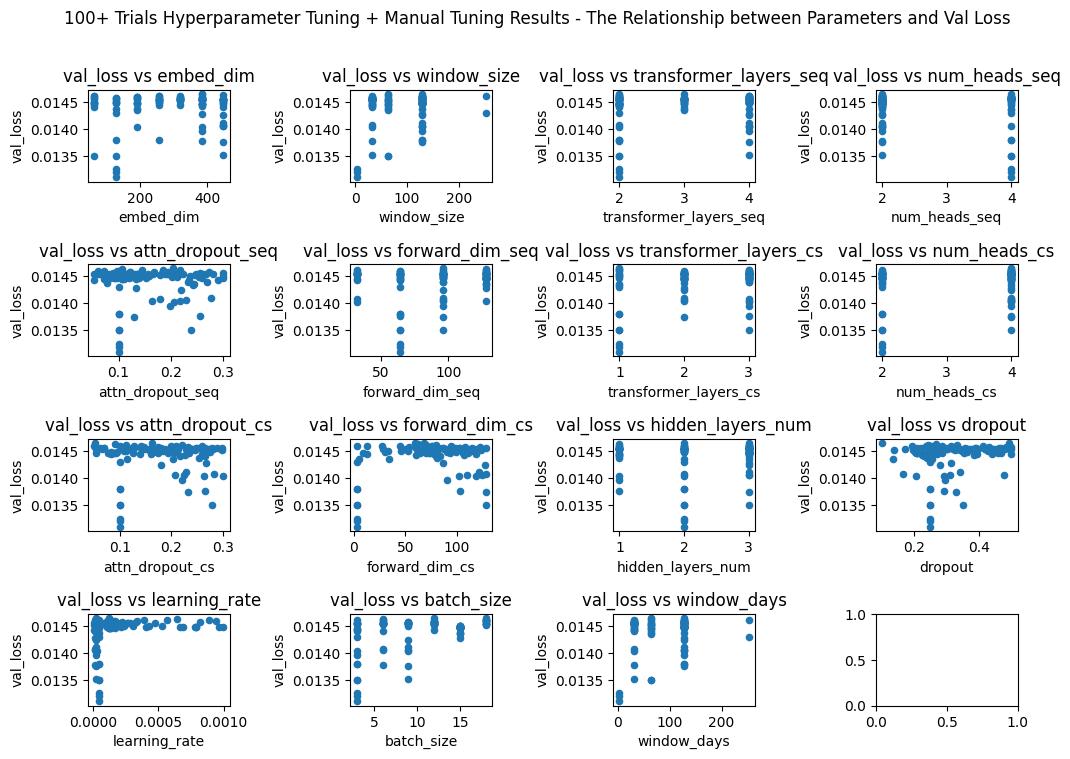

In [66]:
# Quick analysis
param_feat_df = model_res_record.drop(columns=['trial_number','rebal_freq','train_loss','val_loss']) 
# target_loss_df = trail_results['val_loss']

n = len(param_feat_df.columns)
n_per_row=4

# for col in trail_results.drop(columns=['trial_number','train_loss','test_loss']):
                
if n%n_per_row==0:
    n_rows = n//n_per_row
else:
    n_rows = n//n_per_row+1
fig1, ax1 = plt.subplots(n_rows, n_per_row, figsize=(12,8))
for i, col in enumerate(param_feat_df.columns):
    model_res_record[[col]+['val_loss']].plot.scatter(x=col,y='val_loss', ax=ax1[i//n_per_row, i%n_per_row])
    ax1[i//n_per_row, i%n_per_row].set_title(f'val_loss vs {col}')
plt.suptitle('100+ Trials Hyperparameter Tuning + Manual Tuning Results - The Relationship between Parameters and Val Loss')
plt.subplots_adjust(hspace=0.9, wspace=0.85)
plt.show()

In [45]:
# prepare ticker list
weights_path = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\data-related/'
sp_weights = pd.read_excel(weights_path+'S&P500-weights.xlsx')

top_100_ticker_l = sp_weights.iloc[:100,:]['Symbol'].tolist()
top_200_ticker_l = sp_weights.iloc[:200,:]['Symbol'].tolist()
top_300_ticker_l = sp_weights.iloc[:300,:]['Symbol'].tolist()

with open(f'{data_directory}/top_100_ticker_l.pkl', 'wb') as f:
    pickle.dump(top_100_ticker_l, f)

with open(f'{data_directory}/top_200_ticker_l.pkl', 'wb') as f:
    pickle.dump(top_200_ticker_l, f)

with open(f'{data_directory}/top_300_ticker_l.pkl', 'wb') as f:
    pickle.dump(top_300_ticker_l, f)

In [ ]:
# checking loading figures 
axes = fig_perf_train.gca()
axes.set_title('Modified Title')
fig_perf_train

try_file_path = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN\pres3_model_res\Try-for-figure/'

bm_res_dic_comb_test = {
    'portf_rtn':portf_rtn_comb, 
    'portf_mkt_rtn': portf_mkt_rtn_comb, 
    'stats_df': stats_df_comb, 
    'scaler_df': scaler_df_comb, 
    'fig_perf': fig_perf_train, 
    'scaled_weight_df': scaled_weight_df_comb
}

with open(try_file_path+'model_res_record.pkl', 'wb') as f:
    pickle.dump(bm_res_dic_comb_test, f)

In [254]:
with open(try_file_path+'model_res_record.pkl', 'rb') as f:
    bm_res_dic_comb_test_read = pickle.load(f)

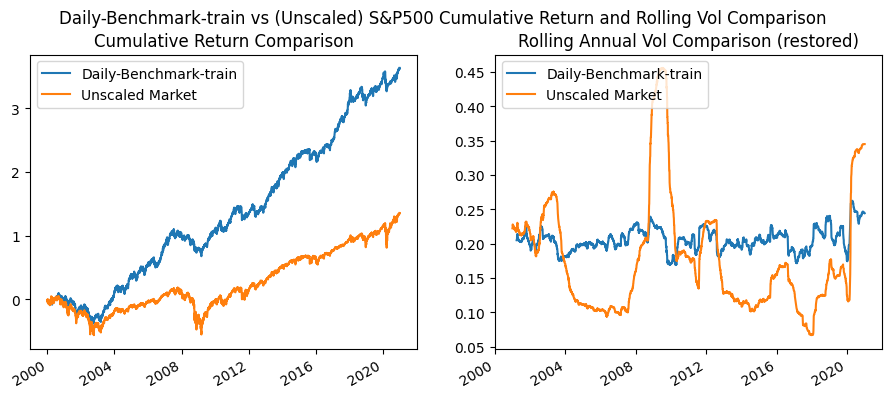

In [258]:
fig_read = bm_res_dic_comb_test_read['fig_perf']
axes = fig_read.gca()
axes.set_title('Rolling Annual Vol Comparison (restored)')
fig_read

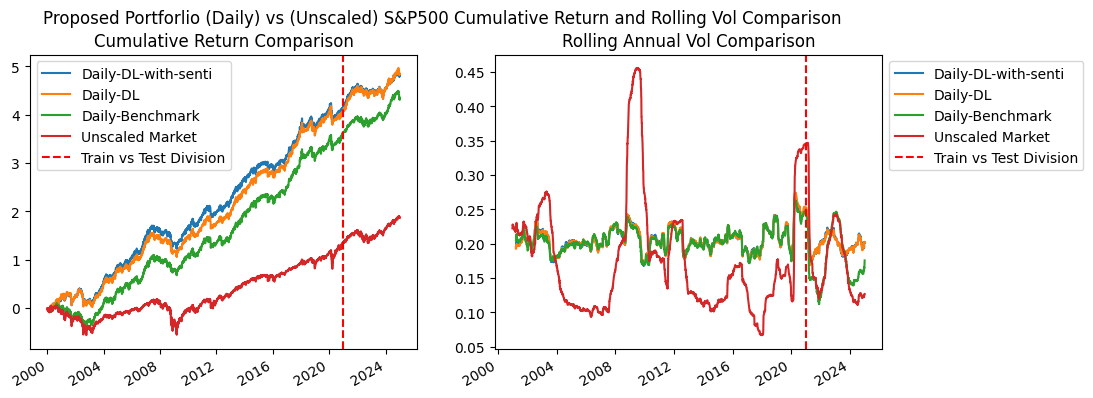

In [ ]:
# %matplotlib inline
import io 
import requests

url ='https://dsp-public-streamlit.s3.us-west-2.amazonaws.com/NN-related/dl_model/dl_model_checkpoint0/D/fig_comb_v1.pkl'
response = requests.get(url)
file_obj = io.BytesIO(response.content)

fig_test = pickle.load(file_obj)
display(fig_test)

In [22]:
pres3_path = r'C:\Mine\U.S.-2019\NPB living - 2 - related\School-part time\Berkeley-202308\MIDS classes\210-Capstone\Project-related\code-IN\pres3_model_res/'

fig_test.savefig(pres3_path+'fig_comb_png_v1', bbox_inches='tight', dpi=300)

# Drafts

In [316]:
## one time regression
reg_param_df = pd.DataFrame(columns=['const']+sel_features_adj)
pred_df = pd.DataFrame()

dates_train = train_used['date'].unique()[20:]

i=0
date_period = dates_train[max(0,i+1-252*1):max(252*1, i+1)]
data_t = train_used[train_used['date'].isin(date_period)]
# data_t['date'].unique()

df_y = data_t['excess_ret']
df_x = data_t[sel_features_adj].apply(lambda x: x*data_t['prev_d_exc_ret'], axis=0).ffill()

x, y, sm_model, model_prefit, param_reg \
    = regression_sm(df_y, df_x)

pred_t = pd.concat([data_t[['date','permno']], sm_model.predict(x).rename('pred_exc_ret')], axis=1)
reg_param_df.loc[date,:] = param_reg

In [ ]:
# date='2000-02-01'
# date='2001-01-31'
date='2020-12-31'
n_multiple = 252 # IN: number of period per ann
exp_exc_rtn = pred_t.groupby('permno')[['date','pred_exc_ret']].apply(lambda x: x.loc[x['date']==date, 'pred_exc_ret']).droplevel(1).replace(np.nan, 0)

return_data = data_t[['date','permno']+['prev_d_exc_ret']].groupby(['date','permno'])['prev_d_exc_ret'].last().unstack()[exp_exc_rtn.index].replace(np.nan, 0)
# cov_matrix = risk_models.sample_cov(return_data, frequency=n_multiple)
# cov_matrix = risk_models.fix_nonpositive_semidefinite(return_data.cov().replace(np.nan,0)*n_multiple, fix_method='diag')
cov_matrix = risk_models.fix_nonpositive_semidefinite(
    pd.DataFrame(LedoitWolf().fit(return_data).covariance_, 
                 index=return_data.columns, columns=return_data.columns)*n_multiple, fix_method='spectral') # fix_method: {"spectral", "diag"}, defaults to "spectral"

# vol_vector = return_data.std()
# corr_df = return_data.corr()
# cov_matrix = risk_models.sample_cov(
#     pd.DataFrame(np.diag(vol_vector).dot(corr_df).dot(np.diag(vol_vector)), 
#                  index=vol_vector.index, columns=vol_vector.index), frequency = 252)


opt_flag = 'max_sharpe'  #IN: 'target_risk' or 'max_sharpe'
target_risk = 0.1  #IN: this is an example of 10% annual portfolio risk

ef_ob = EfficientFrontier(exp_exc_rtn*n_multiple, cov_matrix)
ef_ob._solver = 'CLARABEL' # IN: this solver works for max_sharpe choice, and likely better for 'target_risk' too
# ef_ob._solver_options ={'ECOS':cp.ECOS}
# ef_ob._solver = 'ECOS'

if opt_flag == 'target_risk':
    ef_ob.efficient_risk(target_volatility=target_risk, market_neutral=False)
elif opt_flag == 'max_sharpe':
    ef_ob.max_sharpe()

opt_w_t = pd.DataFrame(ef_ob.clean_weights(), index=[date])
# opt_weight_df = pd.concat([opt_weight_df, opt_w_t])
